In [ ]:
# # Run below commands
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# # !wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
# # !tar xf spark-3.1.2-bin-hadoop3.2.tgz
# !wget -q https://archive.apache.org/dist/spark/spark-3.0.3/spark-3.0.3-bin-hadoop3.2.tgz
# !tar xf spark-3.0.3-bin-hadoop3.2.tgz
# !pip install -q findspark
# !pip install pyspark.sql.functions
# !pip install nltk
# !pip install emoji

In [ ]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# # os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
# os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop3.2"

In [ ]:
!pip install pyspark
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=2badaae2111b48e0e1223ad86ab212dbb470c8adf9727833d6b23e60c1f2728f
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.7/353.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.4.0-py2.py3-none-any.whl size=350809 sha256=27c2c6d6ae485ef919d8e6deb93adc971b4073d02ef080dad5ffe42a3c8df2a4
  Stored in directory: /root/.cache/pip/wheels/79/29/1c/234cae4632803c2ba4a76a71a679eb1383cf590775714e2a21
Succ

In [ ]:
# import findspark
# findspark.init()
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, udf, count, max, sum, when
from pyspark.sql.types import StringType,ArrayType
from pyspark.sql import functions as F

import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#Crete a spark session object
# spark = SparkSession\
#         .builder\
#         .getOrCreate()
spark = SparkSession.builder \
        .master('local[*]') \
        .config('spark.executor.memory', '10gb') \
        .config("spark.cores.max", "8") \
        .config("spark.executor.cores", "6") \
        .config("spark.jars.packages", "graphframes:graphframes:0.8.1-spark3.0-s_2.12") \
        .getOrCreate()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = spark.read.parquet("/content/drive/Shareddrives/BAX423/Homework 4/VenmoSample.snappy.parquet")
data.cache()   # cache to speed up following operations
data.printSchema()  # prints the schema of the data DataFrame

root
 |-- user1: integer (nullable = true)
 |-- user2: integer (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- description: string (nullable = true)
 |-- is_business: boolean (nullable = true)
 |-- story_id: string (nullable = true)



In [ ]:
# increase partition to speed up
data = data.repartition(200)
data.rdd.getNumPartitions()

200

In [ ]:
worddata = spark.read.format("csv") \
  .option("header", "true")  \
  .option("sep", ",") \
.csv("/content/drive/Shareddrives/BAX423/Homework 4/Venmo Word Classification Dictonary BAX-423.csv")

In [ ]:
worddata.printSchema

<bound method DataFrame.printSchema of DataFrame[People: string, Food: string, Event: string, Activity: string, Travel: string, Transportation: string, Utility: string, Cash: string, Illegal/Sarcasm: string, _c9: string, _c10: string, _c11: string, _c12: string]>

In [ ]:
emojidata = spark.read.format("csv") \
.option("inferSchema", "true")\
.option("header", "true")\
.csv("/content/drive/Shareddrives/BAX423/Homework 4/Venmo_Emoji_Classification_Dictionary.csv")

In [ ]:
emojidata.printSchema

<bound method DataFrame.printSchema of DataFrame[Event: string, Travel: string, Food: string, Activity: string, Transportation: string, People: string, Utility: string]>

# Text Analysis

##Q1 Use the text dictionary and the emoji dictionary to classify Venmo’s transactions in your sample dataset

In [ ]:
people_text = [row[0] for row in worddata.select('People').collect()]
food_text = [row[0] for row in worddata.select('Food').collect()]
event_text = [row[0] for row in worddata.select('Event').collect()]
activity_text = [row[0] for row in worddata.select('Activity').collect()]
travel_text = [row[0] for row in worddata.select('Travel').collect()]
transportation_text = [row[0] for row in worddata.select('Transportation').collect()]
utility_text = [row[0] for row in worddata.select('Utility').collect()]
cash_text = [row[0] for row in worddata.select('Cash').collect()]
illegal_text = [row[0] for row in worddata.select('Illegal/Sarcasm').collect()]

In [ ]:
people_emoji = [row[0] for row in emojidata.select('People').collect()]
food_emoji = [row[0] for row in emojidata.select('Food').collect()]
event_emoji = [row[0] for row in emojidata.select('Event').collect()]
activity_emoji = [row[0] for row in emojidata.select('Activity').collect()]
travel_emoji = [row[0] for row in emojidata.select('Travel').collect()]
transportation_emoji = [row[0] for row in emojidata.select('Transportation').collect()]
utility_emoji= [row[0] for row in emojidata.select('Utility').collect()]

In [ ]:
# set the sample fraction
fraction = 0.01 # for example, read 1% of the data

# read a Parquet file and sample the data
data = data.sample(fraction)

# count total number of records
data.count()

71535

In [ ]:
# Tokenize the description column
tokenizer = Tokenizer(inputCol='description', outputCol='tokens')
tokenized_df = tokenizer.transform(data)

In [ ]:
# Remove stop words from the tokens column
remover = StopWordsRemover(inputCol='tokens', outputCol='filtered_tokens')
filtered_df = remover.transform(tokenized_df)

In [ ]:
#Remove
import unicodedata

def remove_punctuation(tokens):
    # Define the regular expression pattern to match whitespace
    pattern = r'\s+'

    # Use re.sub() to remove whitespace and combine the tokens into a single string
    text = re.sub(pattern, ' ', ' '.join(tokens))

    # Use unicodedata to check if each character is in the "Punctuation" category or not
    cleaned_text = ''.join([c for c in text if not unicodedata.category(c).startswith('P')])

    # Use str.split() to split the cleaned text into tokens again
    cleaned_tokens = cleaned_text.split()

    # Return the cleaned tokens as a list
    return cleaned_tokens
remove_punctuation_udf = udf(remove_punctuation, ArrayType(StringType()))

# Apply the UDF to the description column and create a new column called "cleaned_description"
filtered_df = filtered_df.withColumn('cleaned_description', remove_punctuation_udf(col('filtered_tokens')))

In [ ]:
from pyspark.sql.functions import split

def lemmatize(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ','.join(lemmatized)

lemmatize_udf = udf(lemmatize, StringType())

# Apply the lemmatization UDF to the description column
lemmatized_df = filtered_df.withColumn('lemmatized_tokens', lemmatize_udf('cleaned_description'))

# Split the lemmatized tokens into an array of strings
lemmatized_df = lemmatized_df.withColumn('lemmatized_tokens_array', split(col('lemmatized_tokens'), ','))


In [ ]:
from pyspark.sql.functions import udf, col, size, explode, when, array_join

# define a UDF to split emojis into a list of strings
def split_emoji(emoji_list):
    result = []
    for emoji in emoji_list:
        if len(emoji) > 1: # if more than one emoji
            result.extend(list(emoji)) # split into separate strings and add to list
        else:
            result.append(emoji) # add the single emoji as a string
    return result

split_emoji_udf = udf(split_emoji, ArrayType(StringType()))

# create a new column with split emojis
final_df = lemmatized_df.select(
    '*',
    when(array_join(col('lemmatized_tokens_array'), '').rlike('[^\w\s]'),
         split_emoji_udf('lemmatized_tokens_array')).otherwise(col('lemmatized_tokens_array')).alias('split_emoji'))

In [ ]:
columns_to_drop = ['tokens', 'filtered_tokens', 'cleaned_description','lemmatized_tokens','concatenated_tokens']
final_df = final_df.drop(*columns_to_drop)
# final_df.show(10)

In [ ]:
from collections import Counter

def classify_word(words):
    categories = []
    for word in words :
        if (word in people_text) or (word in people_emoji):
            categories.append('People')
        elif (word in food_text) or(word in food_emoji):
            categories.append('Food')
        elif (word in event_text) or word in event_emoji:
            categories.append('Event')
        elif (word in activity_text)  or word in activity_emoji:
            categories.append('Activity')
        elif (word in travel_text) or word in travel_emoji :
            categories.append('Travel')
        elif (word in transportation_text)  or word in transportation_emoji:
            categories.append('Transportation')
        elif (word in utility_text) or word in utility_emoji :
            categories.append('Utility')
        elif (word in cash_text):
            categories.append('Cash')
        elif (word in illegal_text):
            categories.append('Illegal/Sarcasm')
        else:
            categories.append('unclassified')

    if 'unclassified' in categories and len(set(categories)) > 1:
        non_unclassified = [cat for cat in categories if cat != 'unclassified']
        return Counter(non_unclassified).most_common(1)[0][0]

    if categories:
        return Counter(categories).most_common(1)[0][0]
        # return categories
    else:
        return "Other"

classify_udf = udf(classify_word, StringType())
classified_df = final_df.withColumn('classified_tokens', classify_udf(col('split_emoji')))
# classified_df.show(10)

## Q2 What is the percent of emoji only transactions? Which are the top 5 most popular emoji? Which are the top three most popular emoji categories?

In [ ]:
data1=classified_df

In [ ]:
import emoji
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import udf

# UDF to check if a description contains only emojis
def is_emoji_only(text):
    emojis_list = emoji.emoji_list(text)
    return len(text) == len(''.join([item['emoji'] for item in emojis_list]))

is_emoji_only_udf = udf(is_emoji_only, BooleanType())


In [ ]:
# Filter rows where Category is not null and the description contains only emojis
emoji_only_transactions = data1.filter(is_emoji_only_udf(col('description')))
emoji_only_count = emoji_only_transactions.count()
total_count = data.count()
emoji_only_percentage = (emoji_only_count / total_count) * 100

In [ ]:
from pyspark.sql.functions import udf, explode, desc
import re

# UDF to extract emojis from a text
extract_emojis_udf = udf(lambda text: ' '.join(re.findall(r'[\U0001F300-\U0001F64F]', text)), StringType())
data1= data1.withColumn('emojis', extract_emojis_udf(col('description')))

# Finding the top 5 most popular emojis
top_emojis = data1.select(explode(split(col('emojis'), ' ')).alias('emoji')) \
                  .groupBy('emoji') \
                  .count() \
                  .orderBy(desc('count')) \
                  .limit(6)

In [ ]:
# Finding the top 3 emojis categories
top_emoji_cat = data1.select(explode(split(col('description'), r'[^\w\s]')).alias('emoji')) \
                  .filter(col('emoji') != '') \
                  .groupBy('emoji') \
                  .count() \
                  .orderBy(desc('count')) \
                  .limit(4)

In [ ]:
print(f"Pct of emoji-only transactions: {emoji_only_percentage:.2f}%")
# Top 5 most used emojis
print("\nTop 5 most popular emojis:")
top_emojis.show()
# Top 3 most common emoji categories
print("\nTop 3 most popular emoji categories:")
top_emoji_cat.show()

Pct of emoji-only transactions: 24.30%

Top 5 most popular emojis:
+-----+-----+
|emoji|count|
+-----+-----+
|     |48946|
|   🍕| 2482|
|   🐔| 1539|
|   🍻| 1434|
|   💸| 1207|
|   🍷| 1033|
+-----+-----+


Top 3 most popular emoji categories:
+-----+-----+
|emoji|count|
+-----+-----+
|     | 1911|
| Food|  608|
| Uber|  342|
| Rent|  294|
+-----+-----+



Q3 For each user, create a variable to indicate their spending behavior profile.

In [ ]:
classified_df.select("user1", "classified_tokens").show()
#withColumn("transactions_per_class", classified_df.groupBy("user1","class").count()).show()

+-------+-----------------+
|  user1|classified_tokens|
+-------+-----------------+
|2640840|          Utility|
| 182356|             Food|
|4490084|     unclassified|
| 859041|     unclassified|
|2782512|          Utility|
|3508207|             Food|
|3415900|          Utility|
|1372311|     unclassified|
|3113653|             Food|
| 729440|  Illegal/Sarcasm|
|1005158|           People|
|1861774|     unclassified|
|4453087|     unclassified|
|3477173|           People|
|4676618|             Food|
|1121467|          Utility|
|2898107|           People|
|9457853|     unclassified|
|1493841|     unclassified|
|4454624|     unclassified|
+-------+-----------------+
only showing top 20 rows



In [ ]:
classified_df.write.mode("overwrite").parquet("/content/drive/Shareddrives/BAX423/Homework 4/classified_df_data")

In [ ]:
# read parquet file
df_subset = spark.read.parquet('/content/drive/Shareddrives/BAX423/Homework 4/classified_df_data', inferSchema = True, header = True)
df_subset.head

<bound method DataFrame.head of DataFrame[user1: int, user2: int, transaction_type: string, datetime: timestamp, description: string, is_business: boolean, story_id: string, lemmatized_tokens_array: array<string>, split_emoji: array<string>, classified_tokens: string]>

In [ ]:
df_subset.createOrReplaceTempView("df_subset")
df_subset.show()

+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+-----------------------+--------------------+-----------------+
|  user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|lemmatized_tokens_array|         split_emoji|classified_tokens|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+-----------------------+--------------------+-----------------+
|1237583|3169493|         payment|2016-06-08 20:17:59|Prezzies for the ...|      false|57581b07cd03c9af2...|   [prezzies, chucks...|[prezzies, chucks...|     unclassified|
|1090941| 921964|          charge|2015-11-29 07:58:41|                 LFG|      false|565a3fb2cd03c9af2...|                  [lfg]|               [lfg]|     unclassified|
| 164938| 445121|         payment|2016-04-27 11:41:00|              MIYABI|      false|572042dccd03c9af2...|               [miyabi]|        

In [ ]:
df_profile = spark.sql("select user1, classified_tokens, count(*) as transactions_per_class, \
                    concat(round(count(*)/sum(count(*)) over (partition by user1) *100, 2),'%') as ratio \
               from df_subset \
               group by user1, classified_tokens \
               order by user1")
df_profile.show()

+-----+-----------------+----------------------+------+
|user1|classified_tokens|transactions_per_class| ratio|
+-----+-----------------+----------------------+------+
|   43|     unclassified|                     1| 50.0%|
|   43|             Food|                     1| 50.0%|
|  275|             Food|                     1| 50.0%|
|  275|  Illegal/Sarcasm|                     1| 50.0%|
| 1535|     unclassified|                     1|100.0%|
| 3423|     unclassified|                     1|100.0%|
| 3897|             Food|                     1|100.0%|
| 4541|         Activity|                     1|100.0%|
| 4653|             Food|                     1|100.0%|
| 5234|             Food|                     1|100.0%|
| 6680|             Food|                     1| 50.0%|
| 6680|  Illegal/Sarcasm|                     1| 50.0%|
|23415|     unclassified|                     1|100.0%|
|23439|     unclassified|                     1|100.0%|
|25535|     unclassified|                     1|

In [ ]:
# create a list with unique classes
from pyspark.sql.functions import col, when, max
categories = sorted(df_profile.select("classified_tokens").distinct().rdd.map(lambda row: row[0]).collect())

cols = [when(col("classified_tokens") == category, col("ratio")).otherwise(None).alias(category)
    for category in categories]

maxs = [max(col(category)).alias(category) for category in categories]

# create static spending profile for each user
static_profile = (df_profile.select(col("user1"), *cols).groupBy("user1").agg(*maxs).na.fill(0))

static_profile.createOrReplaceTempView("static_profile")
static_profile.show()

+-----+--------+----+-----+------+---------------+------+--------------+------+-------+------------+
|user1|Activity|Cash|Event|  Food|Illegal/Sarcasm|People|Transportation|Travel|Utility|unclassified|
+-----+--------+----+-----+------+---------------+------+--------------+------+-------+------------+
|   43|    null|null| null| 50.0%|           null|  null|          null|  null|   null|       50.0%|
|  275|    null|null| null| 50.0%|          50.0%|  null|          null|  null|   null|        null|
| 1535|    null|null| null|  null|           null|  null|          null|  null|   null|      100.0%|
| 3423|    null|null| null|  null|           null|  null|          null|  null|   null|      100.0%|
| 3897|    null|null| null|100.0%|           null|  null|          null|  null|   null|        null|
| 4541|  100.0%|null| null|  null|           null|  null|          null|  null|   null|        null|
| 4653|    null|null| null|100.0%|           null|  null|          null|  null|   null|    

Q4 For each user, create a dynamic spending profile (12 months)

In [ ]:
# navigate the first transaction date and only keep first 12 months transactions for each user
days_tbl = spark.sql("select user1, user2, datetime, classified_tokens, datediff(datetime, \
                first_value(datetime) over (partition by user1 order by datetime)) as days \
                from df_subset \
                group by user1, user2, datetime, classified_tokens\
                order by user1")
days_tbl.show()

+-----+--------+-------------------+-----------------+----+
|user1|   user2|           datetime|classified_tokens|days|
+-----+--------+-------------------+-----------------+----+
|   43|   49778|2013-01-08 09:39:09|     unclassified|   0|
|   43|   47104|2013-05-22 00:02:28|             Food| 134|
|  275|      11|2015-03-06 13:55:37|  Illegal/Sarcasm|   0|
|  275|12731459|2016-09-02 23:30:24|             Food| 546|
| 1535| 1533540|2016-02-08 23:09:22|     unclassified|   0|
| 3423|  118893|2013-04-15 08:30:58|     unclassified|   0|
| 3897|   81980|2015-01-17 12:07:27|             Food|   0|
| 4541| 2496587|2015-08-11 02:38:07|         Activity|   0|
| 4653|   26251|2012-06-12 00:59:32|             Food|   0|
| 5234| 1221831|2014-04-26 23:46:22|             Food|   0|
| 6680|   41804|2014-02-22 15:40:36|  Illegal/Sarcasm|   0|
| 6680|  237648|2016-04-26 05:35:05|             Food| 794|
|23415| 3443368|2016-06-23 08:48:30|     unclassified|   0|
|23439|  708170|2014-05-14 06:00:34|    

In [ ]:
# add lifetime indiactor (0-12 where 0 represents the 1st transaction and 1 represents 1 month and so on)
days_lifeindicator_tbl = days_tbl.select("*",
            when(days_tbl.days==0, 0)\
         .when((days_tbl.days>0) & (days_tbl.days<=30), 1) \
         .when((days_tbl.days>30) & (days_tbl.days<=60), 2) \
         .when((days_tbl.days>60) & (days_tbl.days<=90), 3)\
         .when((days_tbl.days>90) & (days_tbl.days<=120), 4)\
         .when((days_tbl.days>120) & (days_tbl.days<=150), 5)\
         .when((days_tbl.days>150) & (days_tbl.days<=180), 6)\
         .when((days_tbl.days>180) & (days_tbl.days<=210), 7)\
         .when((days_tbl.days>210) & (days_tbl.days<=240), 8)\
         .when((days_tbl.days>240) & (days_tbl.days<=270), 9)\
         .when((days_tbl.days>270) & (days_tbl.days<=300), 10)\
         .when((days_tbl.days>300) & (days_tbl.days<=330), 11)\
         .when((days_tbl.days>330) & (days_tbl.days<=360), 12)\
         .otherwise(-1).alias('lifetime_indicator'))
days_lifeindicator_tbl.createOrReplaceTempView("days_lifeindicator_tbl")

# filter out records where "datetime-startdate">=360 days (12 months after first transaction)
lifetime_tbl = days_lifeindicator_tbl.filter("lifetime_indicator != -1 ").sort("user1")

lifetime_tbl.show()

+-----+-------+-------------------+-----------------+----+------------------+
|user1|  user2|           datetime|classified_tokens|days|lifetime_indicator|
+-----+-------+-------------------+-----------------+----+------------------+
|   43|  49778|2013-01-08 09:39:09|     unclassified|   0|                 0|
|   43|  47104|2013-05-22 00:02:28|             Food| 134|                 5|
|  275|     11|2015-03-06 13:55:37|  Illegal/Sarcasm|   0|                 0|
| 1535|1533540|2016-02-08 23:09:22|     unclassified|   0|                 0|
| 3423| 118893|2013-04-15 08:30:58|     unclassified|   0|                 0|
| 3897|  81980|2015-01-17 12:07:27|             Food|   0|                 0|
| 4541|2496587|2015-08-11 02:38:07|         Activity|   0|                 0|
| 4653|  26251|2012-06-12 00:59:32|             Food|   0|                 0|
| 5234|1221831|2014-04-26 23:46:22|             Food|   0|                 0|
| 6680|  41804|2014-02-22 15:40:36|  Illegal/Sarcasm|   0|      

In [ ]:
from pyspark.sql.functions import concat, col, lit
lifetime_tbl = lifetime_tbl\
        .withColumn("lifetime_category", concat(lit("time"), col("lifetime_indicator"), lit("_"), col("classified_tokens")))\
        .withColumn("user_life", concat(col("user1"), lit("_"), col("lifetime_indicator")))

lifetime_tbl.createOrReplaceTempView("lifetime_tbl")

dynamic_tbl = spark.sql("select user1, lifetime_indicator, classified_tokens, \
                round(count(*)/sum(count(*)) \
                  over (partition by user1, lifetime_indicator), 2) as percentage \
               from lifetime_tbl \
               group by user1, lifetime_indicator, classified_tokens \
               order by user1")

dynamic_tbl.createOrReplaceTempView("dynamic_tbl")

dynamic_tbl.show()

+-----+------------------+-----------------+----------+
|user1|lifetime_indicator|classified_tokens|percentage|
+-----+------------------+-----------------+----------+
|   43|                 0|     unclassified|       1.0|
|   43|                 5|             Food|       1.0|
|  275|                 0|  Illegal/Sarcasm|       1.0|
| 1535|                 0|     unclassified|       1.0|
| 3423|                 0|     unclassified|       1.0|
| 3897|                 0|             Food|       1.0|
| 4541|                 0|         Activity|       1.0|
| 4653|                 0|             Food|       1.0|
| 5234|                 0|             Food|       1.0|
| 6680|                 0|  Illegal/Sarcasm|       1.0|
|23415|                 0|     unclassified|       1.0|
|23439|                 0|     unclassified|       1.0|
|25535|                 0|     unclassified|       1.0|
|26695|                 0|     unclassified|       1.0|
|27828|                 0|             Food|    

In [ ]:
# create dynamic profile
#spread rows to columns: each row representing one user, each column representing lifetime and spending category

classes = sorted(dynamic_tbl.select("classified_tokens").distinct().rdd.map(lambda row: row[0]).collect())

cols1 = [when(col("classified_tokens") == clas, col("percentage")).otherwise(None).alias(clas)
    for clas in classes]

maxs1 = [max(col(clas)).alias(clas) for clas in classes]

dynamic_profile = (dynamic_tbl.select(col("user1"),
            col("lifetime_indicator"), *cols1)\
            .groupBy("user1", "lifetime_indicator").agg(*maxs1).na.fill(0)\
            .orderBy("user1", "lifetime_indicator"))

dynamic_profile.createOrReplaceTempView("dynamic_profile")

dynamic_profile.show()

+-----+------------------+--------+----+-----+----+---------------+------+--------------+------+-------+------------+
|user1|lifetime_indicator|Activity|Cash|Event|Food|Illegal/Sarcasm|People|Transportation|Travel|Utility|unclassified|
+-----+------------------+--------+----+-----+----+---------------+------+--------------+------+-------+------------+
|   43|                 0|     0.0| 0.0|  0.0| 0.0|            0.0|   0.0|           0.0|   0.0|    0.0|         1.0|
|   43|                 5|     0.0| 0.0|  0.0| 1.0|            0.0|   0.0|           0.0|   0.0|    0.0|         0.0|
|  275|                 0|     0.0| 0.0|  0.0| 0.0|            1.0|   0.0|           0.0|   0.0|    0.0|         0.0|
| 1535|                 0|     0.0| 0.0|  0.0| 0.0|            0.0|   0.0|           0.0|   0.0|    0.0|         1.0|
| 3423|                 0|     0.0| 0.0|  0.0| 0.0|            0.0|   0.0|           0.0|   0.0|    0.0|         1.0|
| 3897|                 0|     0.0| 0.0|  0.0| 1.0|     

In [ ]:
lifetime_tbl.show()

+-----+-------+-------------------+-----------------+----+------------------+--------------------+---------+
|user1|  user2|           datetime|classified_tokens|days|lifetime_indicator|   lifetime_category|user_life|
+-----+-------+-------------------+-----------------+----+------------------+--------------------+---------+
|   43|  49778|2013-01-08 09:39:09|     unclassified|   0|                 0|  time0_unclassified|     43_0|
|   43|  47104|2013-05-22 00:02:28|             Food| 134|                 5|          time5_Food|     43_5|
|  275|     11|2015-03-06 13:55:37|  Illegal/Sarcasm|   0|                 0|time0_Illegal/Sar...|    275_0|
| 1535|1533540|2016-02-08 23:09:22|     unclassified|   0|                 0|  time0_unclassified|   1535_0|
| 3423| 118893|2013-04-15 08:30:58|     unclassified|   0|                 0|  time0_unclassified|   3423_0|
| 3897|  81980|2015-01-17 12:07:27|             Food|   0|                 0|          time0_Food|   3897_0|
| 4541|2496587|2015

In [ ]:
df1 = spark.sql("select user1, lifetime_category, \
                 round(count(*)/sum(count(*)) over (partition by user_life), 2) as percentage \
               from lifetime_tbl \
               group by user1, user_life, lifetime_category \
               order by user1")

life_cates = sorted(df1.select("lifetime_category").distinct().rdd.map(lambda row: row[0]).collect())
cols2 = [when(col("lifetime_category") == life_cate, col("percentage")).otherwise(None).alias(life_cate)
    for life_cate in life_cates]
maxs2 = [max(col(life_cate)).alias(life_cate) for life_cate in life_cates]
dynamic2 = (df1.select(col("user1"), *cols2).groupBy("user1").agg(*maxs2).na.fill(0))


# calculate mean, standard deviation for each time period and each class
summary_stats = dynamic2.summary()
df_dynamic_summary = summary_stats.select("*").toPandas()
df_dynamic_summary = df_dynamic_summary.T.reset_index() # transpose and reset index
headers = df_dynamic_summary.iloc[0] # store new header values
df_dynamic_summary = df_dynamic_summary[2:] # remove user1 information and previous header
df_dynamic_summary.columns = headers
df_dynamic_summary = df_dynamic_summary.reset_index(drop=True)
df_dynamic_summary.head()

0                summary  count                  mean               stddev  \
0         time0_Activity  69226   0.08820385404327853  0.28359318742003325   
1             time0_Cash  69226  0.009346199404847889  0.09622360267415447   
2            time0_Event  69226  0.023560511946378527  0.15167645351643994   
3             time0_Food  69226   0.22166527027417443  0.41536134594930313   
4  time0_Illegal/Sarcasm  69226   0.03451015514402103  0.18253680629796976   

0  min  25%  50%  75%  max  
0  0.0  0.0  0.0  0.0  1.0  
1  0.0  0.0  0.0  0.0  1.0  
2  0.0  0.0  0.0  0.0  1.0  
3  0.0  0.0  0.0  0.0  1.0  
4  0.0  0.0  0.0  0.0  1.0

In [ ]:
# add time and category columns for plotting
import pandas as pd
time = []
category = []

for i in range(len(df_dynamic_summary)):
    pos = df_dynamic_summary.summary[i].index("_")
    c = df_dynamic_summary.summary[i][pos+1:]  # get category
    t = df_dynamic_summary.summary[i][4:pos]   # get lifetime
    time.append(t)
    category.append(c)

df_dynamic_summary["time"] = time
df_dynamic_summary["category"] = category

# convert data type from string to numeric
df_dynamic_summary["time"] = df_dynamic_summary["time"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["mean"] = df_dynamic_summary["mean"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["stddev"] = df_dynamic_summary["stddev"].apply(pd.to_numeric, errors='coerce')
df_dynamic_summary["2std"] = 2*df_dynamic_summary["stddev"]

df_dynamic_summary.head()

0                summary  count      mean    stddev  min  25%  50%  75%  max  \
0         time0_Activity  69226  0.088204  0.283593  0.0  0.0  0.0  0.0  1.0   
1             time0_Cash  69226  0.009346  0.096224  0.0  0.0  0.0  0.0  1.0   
2            time0_Event  69226  0.023561  0.151676  0.0  0.0  0.0  0.0  1.0   
3             time0_Food  69226  0.221665  0.415361  0.0  0.0  0.0  0.0  1.0   
4  time0_Illegal/Sarcasm  69226  0.034510  0.182537  0.0  0.0  0.0  0.0  1.0   

0  time         category      2std  
0     0         Activity  0.567186  
1     0             Cash  0.192447  
2     0            Event  0.303353  
3     0             Food  0.830723  
4     0  Illegal/Sarcasm  0.365074

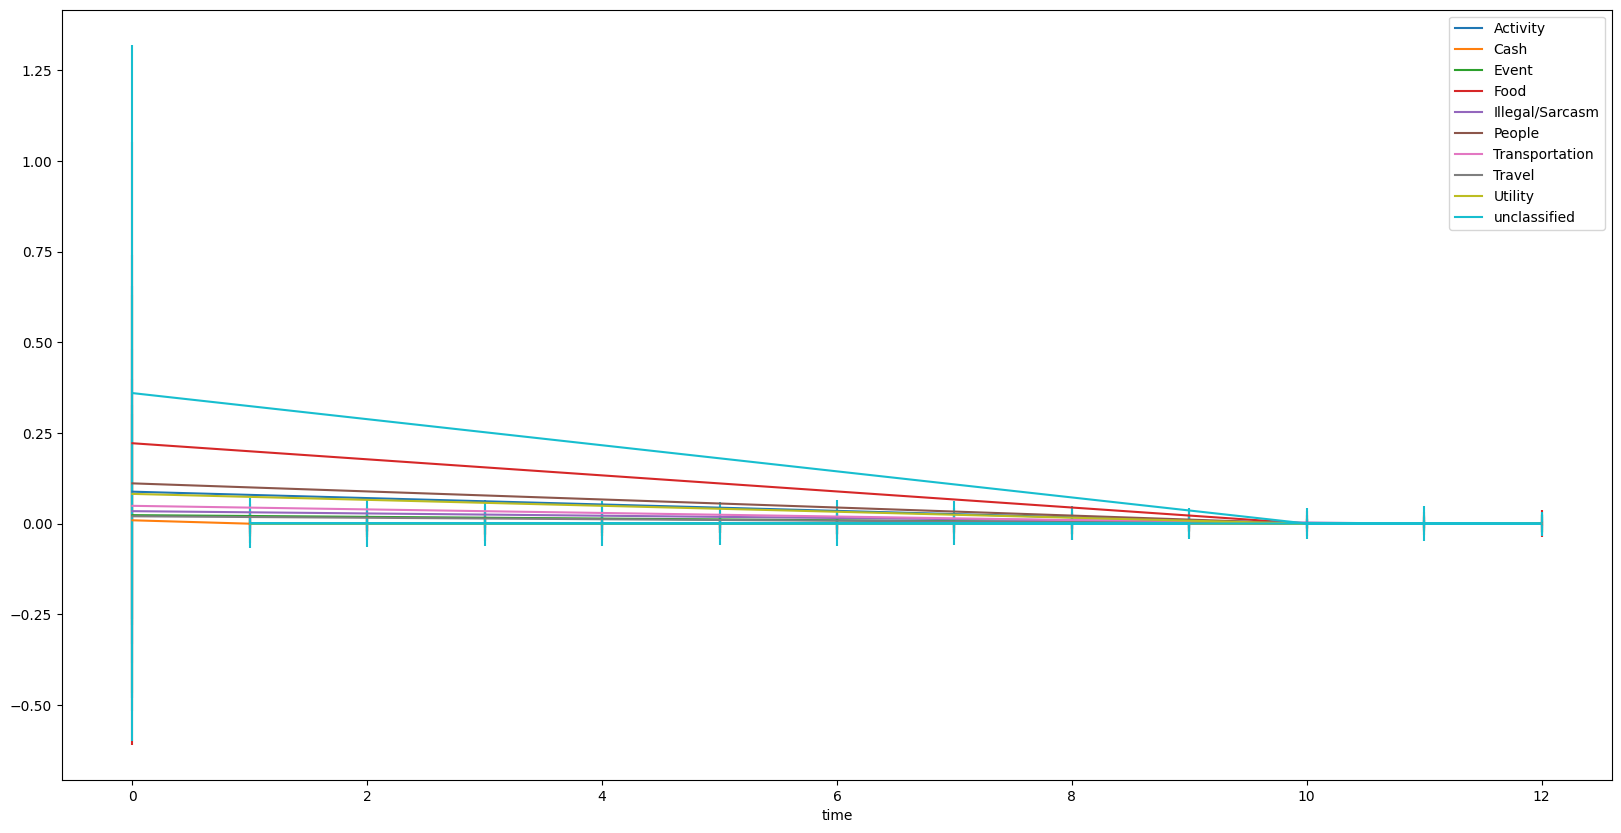

In [ ]:
# plot the graph
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))

for key, group in df_dynamic_summary.groupby('category'):
    group.plot('time', 'mean', yerr='2std', label=key, ax=ax)

plt.show()


# after lifetime 10, the mean for all categories spendings tend to be stable and close to zero.

# Social Network Analysis

## Q5

### Friends

In [ ]:
df_friends = df_subset.select(col('user1').alias('Users'), col('user2').alias('Friends')).distinct().sort('user1')
df_friends.show()

+-----+--------+
|Users| Friends|
+-----+--------+
|   43|   49778|
|   43|   47104|
|  275|12731459|
|  275|      11|
| 1535| 1533540|
| 3423|  118893|
| 3897|   81980|
| 4541| 2496587|
| 4653|   26251|
| 5234| 1221831|
| 6680|  237648|
| 6680|   41804|
|23415| 3443368|
|23439|  708170|
|25535|  125842|
|26695|  156060|
|27828|   64147|
|29214|    4276|
|29489|   31249|
|29514|  110929|
+-----+--------+
only showing top 20 rows



### Friends of friends

In [ ]:
df_FoF = df_subset.alias('df1').join(df_subset.alias('df2'), col('df1.user2') == col('df2.user1'),"inner") \
.select(col('df1.user1').alias('Users'),col('df1.user2').alias('Friend'), col('df2.user2').alias('Friends of friends')).where(col('df1.user1')!=col('df2.user2')) \
.distinct().sort('df1.user1')
df_FoF.show()


+------+-------+------------------+
| Users| Friend|Friends of friends|
+------+-------+------------------+
| 30655|  29489|             31249|
| 43347| 217112|            167874|
| 56652|  56700|             80426|
| 59203|1047595|            958752|
| 69206|  99103|           1137195|
| 72369| 215794|           2143104|
| 72612| 335629|            241968|
| 72730| 206997|            659387|
| 72730|  61218|             68936|
| 77747|  61218|             68936|
| 85171| 160941|           4444147|
| 85652|  88382|            216833|
| 91812|  81135|            473893|
| 94540|  89942|             68703|
|105669|  77135|             64034|
|111070| 112036|            210291|
|112760|1770210|            838582|
|112760|1770210|           1842802|
|112760|1770210|            929764|
|114081| 441858|           2586900|
+------+-------+------------------+
only showing top 20 rows



In [ ]:
df_friends_computation = df_friends.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [Users#28938, Friends#28939]
   +- Sort [user1#29044 ASC NULLS FIRST], true, 0
      +- Exchange rangepartitioning(user1#29044 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=3677]
         +- HashAggregate(keys=[Users#28938, Friends#28939], functions=[first(user1#1783, false)])
            +- Exchange hashpartitioning(Users#28938, Friends#28939, 200), ENSURE_REQUIREMENTS, [plan_id=3674]
               +- HashAggregate(keys=[Users#28938, Friends#28939], functions=[partial_first(user1#1783, false)])
                  +- Project [user1#1783 AS Users#28938, user2#1784 AS Friends#28939, user1#1783]
                     +- FileScan parquet [user1#1783,user2#1784] Batched: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[file:/content/drive/Shareddrives/BAX423/Homework 4/classified_df_data], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<user1:int,user2:int>




In [ ]:
df_FoF_computation = df_FoF.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [Users#29012, Friend#29013, Friends of friends#29014]
   +- Sort [user1#29050 ASC NULLS FIRST], true, 0
      +- Exchange rangepartitioning(user1#29050 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=3733]
         +- HashAggregate(keys=[Users#29012, Friend#29013, Friends of friends#29014], functions=[first(user1#1783, false)])
            +- Exchange hashpartitioning(Users#29012, Friend#29013, Friends of friends#29014, 200), ENSURE_REQUIREMENTS, [plan_id=3730]
               +- HashAggregate(keys=[Users#29012, Friend#29013, Friends of friends#29014], functions=[partial_first(user1#1783, false)])
                  +- Project [user1#1783 AS Users#29012, user2#1784 AS Friend#29013, user2#28962 AS Friends of friends#29014, user1#1783]
                     +- BroadcastHashJoin [user2#1784], [user1#28961], Inner, BuildRight, NOT (user1#1783 = user2#28962), false
                        :- Filter (isnotnull(user1#1783) A

## Q6

In [ ]:
df_subset.createOrReplaceTempView("df_subset")
df_subset.show()

+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+-----------------------+--------------------+-----------------+
|  user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|lemmatized_tokens_array|         split_emoji|classified_tokens|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+-----------------------+--------------------+-----------------+
|1237583|3169493|         payment|2016-06-08 20:17:59|Prezzies for the ...|      false|57581b07cd03c9af2...|   [prezzies, chucks...|[prezzies, chucks...|     unclassified|
|1090941| 921964|          charge|2015-11-29 07:58:41|                 LFG|      false|565a3fb2cd03c9af2...|                  [lfg]|               [lfg]|     unclassified|
| 164938| 445121|         payment|2016-04-27 11:41:00|              MIYABI|      false|572042dccd03c9af2...|               [miyabi]|        

In [ ]:
lifetime_tbl.createOrReplaceTempView("lifetime_tbl")

lifetime_tbl.show(10)

+-----+-------+-------------------+-----------------+----+------------------+--------------------+---------+
|user1|  user2|           datetime|classified_tokens|days|lifetime_indicator|   lifetime_category|user_life|
+-----+-------+-------------------+-----------------+----+------------------+--------------------+---------+
|   43|  49778|2013-01-08 09:39:09|     unclassified|   0|                 0|  time0_unclassified|     43_0|
|   43|  47104|2013-05-22 00:02:28|             Food| 134|                 5|          time5_Food|     43_5|
|  275|     11|2015-03-06 13:55:37|  Illegal/Sarcasm|   0|                 0|time0_Illegal/Sar...|    275_0|
| 1535|1533540|2016-02-08 23:09:22|     unclassified|   0|                 0|  time0_unclassified|   1535_0|
| 3423| 118893|2013-04-15 08:30:58|     unclassified|   0|                 0|  time0_unclassified|   3423_0|
| 3897|  81980|2015-01-17 12:07:27|             Food|   0|                 0|          time0_Food|   3897_0|
| 4541|2496587|2015

#### Friends

In [ ]:
# number of friends for t=0 to 12
df_n_friends = spark.sql("select distinct user1 as user, lifetime_indicator, count(distinct user2) as no_of_friends from \
                    (select distinct user1, user2, lifetime_indicator from lifetime_tbl \
                    union select distinct user2, user1, lifetime_indicator from lifetime_tbl) T\
                   group by user1, lifetime_indicator \
                   order by user")

df_n_friends.createOrReplaceTempView("df_n_friends")


In [ ]:
# create continuous user lifetime
t_list = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_usertime = df_n_friends.select("user").withColumn("time_list", F.array([F.lit(x) for x in t_list]))
df_usertime = df_usertime.withColumn("time_list", F.explode(col("time_list")))
df_usertime.createOrReplaceTempView("df_usertime")

df_lifetime_friends = spark.sql("select user, lifetime_indicator, max(ifnull(no_of_friends,0)) as no_of_friends from \
                        (select user, lifetime_indicator, no_of_friends from df_n_friends \
                          union \
                         select user, time_list, null as no_of_friends from df_usertime) T \
                        group by user, lifetime_indicator \
                        order by user, lifetime_indicator")
df_lifetime_friends.createOrReplaceTempView("df_lifetime_friends")
df_lifetime_friends.show()

+----+------------------+-------------+
|user|lifetime_indicator|no_of_friends|
+----+------------------+-------------+
|  11|                 0|            2|
|  11|                 1|            0|
|  11|                 2|            0|
|  11|                 3|            0|
|  11|                 4|            0|
|  11|                 5|            0|
|  11|                 6|            0|
|  11|                 7|            0|
|  11|                 8|            0|
|  11|                 9|            0|
|  11|                10|            0|
|  11|                11|            0|
|  11|                12|            0|
|  43|                 0|            1|
|  43|                 1|            0|
|  43|                 2|            0|
|  43|                 3|            0|
|  43|                 4|            0|
|  43|                 5|            1|
|  43|                 6|            0|
+----+------------------+-------------+
only showing top 20 rows



In [ ]:
# continuous lifetime, number of friends, cumulative number of friends
df_total_friends = spark.sql("select user, lifetime_indicator, no_of_friends, \
                                        (sum(no_of_friends) over (partition by user \
                                        order by lifetime_indicator)) as total_friends \
                                    from df_lifetime_friends \
                                    order by user, lifetime_indicator ")

df_total_friends.createOrReplaceTempView("df_total_friends")
df_total_friends.show()


+----+------------------+-------------+-------------+
|user|lifetime_indicator|no_of_friends|total_friends|
+----+------------------+-------------+-------------+
|  11|                 0|            2|            2|
|  11|                 1|            0|            2|
|  11|                 2|            0|            2|
|  11|                 3|            0|            2|
|  11|                 4|            0|            2|
|  11|                 5|            0|            2|
|  11|                 6|            0|            2|
|  11|                 7|            0|            2|
|  11|                 8|            0|            2|
|  11|                 9|            0|            2|
|  11|                10|            0|            2|
|  11|                11|            0|            2|
|  11|                12|            0|            2|
|  43|                 0|            1|            1|
|  43|                 1|            0|            1|
|  43|                 2|   

#### Friends of friends

In [ ]:
# number of friends of friends for t=0 to 12
df_fof_friends = spark.sql("select distinct user1 as user, lifetime_indicator, count(distinct user2) as no_of_friends_of_friends from \
                                (select user1, (case when user2 is null then 0 else user2 end) as user2, lifetime_indicator from \
                                (select distinct a.user1, b.user2, a.lifetime_indicator from lifetime_tbl a \
                                left join lifetime_tbl b on a.user2 = b.user1 where a.user1 <> b.user2) T) W\
                              group by user1, lifetime_indicator \
                              order by user")

df_fof_friends.createOrReplaceTempView("df_fof_friends")
df_fof_friends.show()

+------+------------------+------------------------+
|  user|lifetime_indicator|no_of_friends_of_friends|
+------+------------------+------------------------+
| 43347|                 0|                       1|
| 56652|                 0|                       1|
| 59203|                 0|                       1|
| 69206|                 0|                       1|
| 72369|                 0|                       1|
| 72612|                 0|                       1|
| 72730|                 0|                       1|
| 72730|                 1|                       1|
| 77747|                 0|                       1|
| 85171|                 0|                       1|
| 85652|                 0|                       1|
| 91812|                 0|                       1|
| 94540|                 0|                       1|
|105669|                 0|                       1|
|112760|                 0|                       2|
|114081|                 0|                   

In [ ]:
df_fof_friends = spark.sql("select user1 as user,sum(case when user2 is null then 0 else 1 end) as no_of_friends_of_friends,lifetime_indicator from \
                                (select distinct a.user1, b.user2,a.lifetime_indicator as lifetime_indicator \
                                from lifetime_tbl a \
                                left join lifetime_tbl b on a.user2 = b.user1 ) T \
                                group by user1, lifetime_indicator \
                                order by user")

# df_fof_friends.where(df_fof_friends.user == 45155).show()

In [ ]:
# create continuous user lifetime
t_list = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_usertime = df_fof_friends.select("user").withColumn("time_list", F.array([F.lit(x) for x in t_list]))
df_usertime = df_usertime.withColumn("time_list", F.explode(col("time_list")))
df_usertime.createOrReplaceTempView("df_usertime")

df_lifetime_fof = spark.sql("select user, lifetime_indicator, max(ifnull(no_of_friends_of_friends,0)) as no_of_friends_of_friends from \
                        (select user, lifetime_indicator, no_of_friends_of_friends from df_fof_friends \
                          union \
                         select user, time_list, null as no_of_friends_of_friends from df_usertime) T \
                        group by user, lifetime_indicator \
                        order by user, lifetime_indicator")
df_lifetime_fof.createOrReplaceTempView("df_lifetime_fof")

In [ ]:
df_fof_friends_cumulative = spark.sql("select user, lifetime_indicator, no_of_friends_of_friends, \
                                        (sum(no_of_friends_of_friends) over (partition by user order by lifetime_indicator)) as total_friend_of_friends \
                                    from df_lifetime_fof \
                                    order by user, lifetime_indicator ")
df_fof_friends_cumulative.show()

+----+------------------+------------------------+-----------------------+
|user|lifetime_indicator|no_of_friends_of_friends|total_friend_of_friends|
+----+------------------+------------------------+-----------------------+
|  43|                 0|                       0|                      0|
|  43|                 1|                       0|                      0|
|  43|                 2|                       0|                      0|
|  43|                 3|                       0|                      0|
|  43|                 4|                       0|                      0|
|  43|                 5|                       0|                      0|
|  43|                 6|                       0|                      0|
|  43|                 7|                       0|                      0|
|  43|                 8|                       0|                      0|
|  43|                 9|                       0|                      0|
|  43|                10|

#### Clustering coefficient

In [ ]:
df_edges = spark.sql("select user1 as src, user2 as dst, datetime as transaction_date, lifetime_indicator from lifetime_tbl order by user1")

df_edges.show()

+-----+-------+-------------------+------------------+
|  src|    dst|   transaction_date|lifetime_indicator|
+-----+-------+-------------------+------------------+
|   43|  49778|2013-01-08 09:39:09|                 0|
|   43|  47104|2013-05-22 00:02:28|                 5|
|  275|     11|2015-03-06 13:55:37|                 0|
| 1535|1533540|2016-02-08 23:09:22|                 0|
| 3423| 118893|2013-04-15 08:30:58|                 0|
| 3897|  81980|2015-01-17 12:07:27|                 0|
| 4541|2496587|2015-08-11 02:38:07|                 0|
| 4653|  26251|2012-06-12 00:59:32|                 0|
| 5234|1221831|2014-04-26 23:46:22|                 0|
| 6680|  41804|2014-02-22 15:40:36|                 0|
|23415|3443368|2016-06-23 08:48:30|                 0|
|23439| 708170|2014-05-14 06:00:34|                 0|
|25535| 125842|2013-08-24 08:41:44|                 0|
|26695| 156060|2014-09-18 01:42:00|                 0|
|27828|  64147|2014-12-27 12:17:38|                 0|
|29214|   

In [ ]:
df_vertices = spark.sql("select user1 as vertex from lifetime_tbl union select user2 as vertex from lifetime_tbl ")

df_vertices.show()

+------+
|vertex|
+------+
| 51415|
|112020|
|124967|
|135867|
|143737|
|147280|
|147524|
|186486|
|191933|
|194478|
|213630|
|215820|
|234973|
|239049|
|243119|
|259849|
|275204|
|282566|
|286108|
|287992|
+------+
only showing top 20 rows



In [ ]:
!pip install networkx
!pip install graphframes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
import networkx as nx
from graphframes import GraphFrame

In [ ]:
from graphframes import *
from graphframes.examples import Graphs
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
window = Window.orderBy(F.col('vertex'))
df_final = df_vertices.withColumn('id', F.row_number().over(window))
df_final.select('id', 'vertex').show()

+---+------+
| id|vertex|
+---+------+
|  1|    11|
|  2|    43|
|  3|   173|
|  4|   241|
|  5|   275|
|  6|   634|
|  7|   946|
|  8|  1125|
|  9|  1535|
| 10|  1572|
| 11|  1581|
| 12|  2327|
| 13|  2407|
| 14|  2604|
| 15|  2763|
| 16|  2908|
| 17|  2915|
| 18|  2993|
| 19|  3111|
| 20|  3352|
+---+------+
only showing top 20 rows



In [ ]:
# Create a GraphFrame from the vertices and edges DataFrames
def createGraph(edges):
  return GraphFrame(df_final, edges)

In [ ]:
# Clustering coeff for lifetime t=0 to t=12
clustering_coeff_df = pd.DataFrame()
for t in range(0,13):
  df_edges_t = df_edges.filter(df_edges.lifetime_indicator <= t)
  graph = createGraph(df_edges_t)
  vertices = graph.vertices.toPandas()
  edges = graph.edges.toPandas()
  nx_graph = nx.Graph()
  # Add vertices
  for _, row in vertices.iterrows():
    nx_graph.add_node(row['vertex'])

  # Add edges
  for _, row in edges.iterrows():
    nx_graph.add_edge(row['src'], row['dst'])

  clustering_coeff = nx.clustering(nx_graph)

  clustering_coeff_t = pd.DataFrame(list(clustering_coeff.items()), columns=['vertex', 'clustering_coeff'])
  clustering_coeff_t['lifetime_indicator'] = t

  clustering_coeff_df = clustering_coeff_df.append(clustering_coeff_t, ignore_index=True)


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
<ipython-input-63-d2f7e8e80f79>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clustering_coeff_df = clustering_coeff_df.append(clustering_coeff_t, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pysp

In [ ]:
clustering_coeff = spark.createDataFrame(clustering_coeff_df)

# Create or replace temporary view
clustering_coeff.createOrReplaceTempView("clustering_coeff")
clustering_coeff.show()

+------+----------------+------------------+
|vertex|clustering_coeff|lifetime_indicator|
+------+----------------+------------------+
|    11|             0.0|                 0|
|    43|             0.0|                 0|
|   173|             0.0|                 0|
|   241|             0.0|                 0|
|   275|             0.0|                 0|
|   634|             0.0|                 0|
|   946|             0.0|                 0|
|  1125|             0.0|                 0|
|  1535|             0.0|                 0|
|  1572|             0.0|                 0|
|  1581|             0.0|                 0|
|  2327|             0.0|                 0|
|  2407|             0.0|                 0|
|  2604|             0.0|                 0|
|  2763|             0.0|                 0|
|  2908|             0.0|                 0|
|  2915|             0.0|                 0|
|  2993|             0.0|                 0|
|  3111|             0.0|                 0|
|  3352|  

In [ ]:
## Clustering over the lifetime t=12
graph = createGraph(df_edges)
vertices = graph.vertices.toPandas()
edges = graph.edges.toPandas()
nx_graph = nx.Graph()
# Add vertices
for _, row in vertices.iterrows():
  nx_graph.add_node(row['vertex'])

# Add edges
for _, row in edges.iterrows():
  nx_graph.add_edge(row['src'], row['dst'])

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [ ]:
clustering_coeff2 = nx.clustering(nx_graph)
clustering_coeff2

{11: 0,
 43: 0,
 173: 0,
 241: 0,
 275: 0,
 634: 0,
 946: 0,
 1125: 0,
 1535: 0,
 1572: 0,
 1581: 0,
 2327: 0,
 2407: 0,
 2604: 0,
 2763: 0,
 2908: 0,
 2915: 0,
 2993: 0,
 3111: 0,
 3352: 0,
 3423: 0,
 3463: 0,
 3897: 0,
 3924: 0,
 4276: 0,
 4399: 0,
 4541: 0,
 4642: 0,
 4653: 0,
 4665: 0,
 4748: 0,
 5234: 0,
 6167: 0,
 6442: 0,
 6680: 0,
 6801: 0,
 20012: 0,
 20255: 0,
 20482: 0,
 20594: 0,
 20986: 0,
 21070: 0,
 21090: 0,
 21172: 0,
 21632: 0,
 21837: 0,
 21887: 0,
 21913: 0,
 21940: 0,
 22190: 0,
 22739: 0,
 22777: 0,
 22921: 0,
 23415: 0,
 23439: 0,
 23634: 0,
 23689: 0,
 23913: 0,
 24046: 0,
 24645: 0,
 25330: 0,
 25404: 0,
 25535: 0,
 26247: 0,
 26251: 0,
 26316: 0,
 26384: 0,
 26470: 0,
 26536: 0,
 26695: 0,
 26855: 0,
 27333: 0,
 27426: 0,
 27722: 0,
 27802: 0,
 27828: 0,
 27919: 0,
 28060: 0,
 28744: 0,
 29212: 0,
 29214: 0,
 29489: 0,
 29514: 0,
 29639: 0,
 29852: 0,
 30092: 0,
 30582: 0,
 30600: 0,
 30655: 0,
 30692: 0,
 30946: 0,
 31249: 0,
 32017: 0,
 32184: 0,
 32200: 0,


In [ ]:
# covert dictionary to pyspark dateframe
df_clustercoef_lf = pd.DataFrame(clustering_coeff2.items(), columns=['user', 'clustercoef'])
df_clustercoef_lf = spark.createDataFrame(df_clustercoef_lf)
df_clustercoef_lf.createOrReplaceTempView("df_clustercoef_lf")
df_clustercoef_lf.show()

+----+-----------+
|user|clustercoef|
+----+-----------+
|  11|        0.0|
|  43|        0.0|
| 173|        0.0|
| 241|        0.0|
| 275|        0.0|
| 634|        0.0|
| 946|        0.0|
|1125|        0.0|
|1535|        0.0|
|1572|        0.0|
|1581|        0.0|
|2327|        0.0|
|2407|        0.0|
|2604|        0.0|
|2763|        0.0|
|2908|        0.0|
|2915|        0.0|
|2993|        0.0|
|3111|        0.0|
|3352|        0.0|
+----+-----------+
only showing top 20 rows



### PageRank

In [ ]:
tree_degree = graph.degrees
tree_degree.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+-------+------+
|     id|degree|
+-------+------+
|  51415|     1|
| 112020|     1|
|3343816|     1|
| 149177|     1|
|  97186|     1|
| 124967|     1|
| 135867|     1|
| 220674|     1|
|  51123|     1|
| 143737|     1|
| 147280|     1|
| 147524|     1|
| 243119|     2|
|1375584|     1|
|4384862|     1|
|3646197|     1|
| 186486|     2|
| 178199|     2|
| 191933|     1|
| 104064|     1|
+-------+------+
only showing top 20 rows



In [ ]:
def plot_undirected_graph(edge_list):
    # edge list contains infor,ation about edges which have clear direction
    # hoowever we will diregard the the direction in this function
    # the first thing is to plot the figure
    plt.figure(figsize=(90,90))
    # we instantiate a networkx graoh object.
    # nx. graoh represents an undirected graph.
    gplot=nx.Graph()
    for row in edge_list.select("src", "dst").take(1000):
        gplot.add_edge(row["src"], row["dst"])
    nx.draw(gplot, with_labels=True, font_weight="bold", node_size=350)
plot_undirected_graph(graph.edges)

In [ ]:
page_Rank_list = []
for t in range(0,13):
  df_edges_t = df_edges.filter(df_edges.lifetime_indicator <= t)
  graph = createGraph(df_edges_t)
  vertices = graph.vertices.toPandas()
  edges = graph.edges.toPandas()
  nx_graph = nx.Graph()
  # Add vertices
  for _, row in vertices.iterrows():
    nx_graph.add_node(row['vertex'])

  # Add edges
  for _, row in edges.iterrows():
    nx_graph.add_edge(row['src'], row['dst'])

  page_rank = nx.pagerank(nx_graph)
  page_Rank_list.append(page_rank)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/lib/python3.10/dist-packages/pysp

In [ ]:
page_Rank_list

[{11: 1.3775752493937309e-05,
  43: 7.475255866556092e-06,
  173: 7.475255866556092e-06,
  241: 7.475255866556092e-06,
  275: 4.325007552865484e-06,
  634: 7.475255866556092e-06,
  946: 4.325007552865484e-06,
  1125: 7.475255866556092e-06,
  1535: 7.475255866556092e-06,
  1572: 7.475255866556092e-06,
  1581: 7.475255866556092e-06,
  2327: 7.475255866556092e-06,
  2407: 7.475255866556092e-06,
  2604: 7.475255866556092e-06,
  2763: 7.475255866556092e-06,
  2908: 7.475255866556092e-06,
  2915: 7.475255866556092e-06,
  2993: 7.475255866556092e-06,
  3111: 7.475255866556092e-06,
  3352: 1.1747592391748759e-06,
  3423: 7.475255866556092e-06,
  3463: 7.475255866556092e-06,
  3897: 7.475255866556092e-06,
  3924: 7.475255866556092e-06,
  4276: 7.475255866556092e-06,
  4399: 1.1747592391748759e-06,
  4541: 7.475255866556092e-06,
  4642: 7.475255866556092e-06,
  4653: 7.475255866556092e-06,
  4665: 7.475255866556092e-06,
  4748: 7.475255866556092e-06,
  5234: 7.475255866556092e-06,
  6167: 7.4752

As we can see the page rank remains the same througout the differents lifetime points of a user. Hence we will caculate the pagerank for the entire lifetime

In [ ]:
family_tree = GraphFrame(df_final, df_edges)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [ ]:
vertices = family_tree.vertices.toPandas()
edges = family_tree.edges.toPandas()
nx_graph = nx.Graph()
# Add vertices
for _, row in vertices.iterrows():
    nx_graph.add_node(row['vertex'])

# Add edges
for _, row in edges.iterrows():
    nx_graph.add_edge(row['src'], row['dst'])

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [ ]:
pagerank = nx.pagerank(nx_graph)
dict(list(pagerank.items())[0:10])

{11: 1.3712845600770884e-05,
 43: 1.3712845600770884e-05,
 173: 7.412348973389667e-06,
 241: 7.412348973389667e-06,
 275: 4.262100659699059e-06,
 634: 7.412348973389667e-06,
 946: 4.262100659699059e-06,
 1125: 7.412348973389667e-06,
 1535: 7.412348973389667e-06,
 1572: 7.412348973389667e-06}

In [ ]:
# covert dictionary to pyspark dateframe
df_pagerank = pd.DataFrame(pagerank.items(), columns=['user', 'pagerank'])
df_pagerank = spark.createDataFrame(df_pagerank)
df_pagerank.createOrReplaceTempView("df_pagerank")
df_pagerank.show()

+----+--------------------+
|user|            pagerank|
+----+--------------------+
|  11|1.371284560077088...|
|  43|1.371284560077088...|
| 173|7.412348973389667E-6|
| 241|7.412348973389667E-6|
| 275|4.262100659699059E-6|
| 634|7.412348973389667E-6|
| 946|4.262100659699059E-6|
|1125|7.412348973389667E-6|
|1535|7.412348973389667E-6|
|1572|7.412348973389667E-6|
|1581|7.412348973389667E-6|
|2327|7.412348973389667E-6|
|2407|7.412348973389667E-6|
|2604|7.412348973389667E-6|
|2763|7.412348973389667E-6|
|2908|7.412348973389667E-6|
|2915|7.412348973389667E-6|
|2993|7.412348973389667E-6|
|3111|7.412348973389667E-6|
|3352|4.262100659699059E-6|
+----+--------------------+
only showing top 20 rows



# Predictive Analytics with MLlib

### Calculate the Y (response) variable - no of transactions for each user

In [ ]:
df_with_response = spark.sql("select user1, count(1) as y from lifetime_tbl group by user1 order by user1")
df_with_response.createOrReplaceTempView("df_with_response")
df_with_response.show()

+-----+---+
|user1|  y|
+-----+---+
|   43|  2|
|  275|  1|
| 1535|  1|
| 3423|  1|
| 3897|  1|
| 4541|  1|
| 4653|  1|
| 5234|  1|
| 6680|  1|
|23415|  1|
|23439|  1|
|25535|  1|
|26695|  1|
|27828|  1|
|29214|  1|
|29489|  1|
|29514|  1|
|29639|  1|
|30582|  1|
|30655|  1|
+-----+---+
only showing top 20 rows



### Recency and Frequency variables

In [ ]:
df_freq= lifetime_tbl.groupby('user1','lifetime_indicator').agg(count('*').alias('frequency'), max(col("days")).alias("max_days"))
df_freq.show()

+-----+------------------+---------+--------+
|user1|lifetime_indicator|frequency|max_days|
+-----+------------------+---------+--------+
|   43|                 0|        1|       0|
|   43|                 5|        1|     134|
|  275|                 0|        1|       0|
| 1535|                 0|        1|       0|
| 3423|                 0|        1|       0|
| 3897|                 0|        1|       0|
| 4541|                 0|        1|       0|
| 4653|                 0|        1|       0|
| 5234|                 0|        1|       0|
| 6680|                 0|        1|       0|
|23415|                 0|        1|       0|
|23439|                 0|        1|       0|
|25535|                 0|        1|       0|
|26695|                 0|        1|       0|
|27828|                 0|        1|       0|
|29214|                 0|        1|       0|
|29489|                 0|        1|       0|
|29514|                 0|        1|       0|
|29639|                 0|        

In [ ]:
t_list = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_timelist = df_with_response.withColumn('time', F.array([F.lit(x) for x in t_list]))
df_timelist = df_timelist.withColumn('time', F.explode(col('time')))

In [ ]:
df_time_freq = df_freq.select('user1','lifetime_indicator','max_days', 'frequency') \
    .union(df_timelist.select("user1", 'time', lit(None).alias('max_days'), lit(None).alias('frequency'))) \
    .groupby('user1', 'lifetime_indicator') \
    .agg(max(col('max_days')).alias('max_days'), max(col('frequency')).alias('frequency')) \
    .orderBy('user1', 'lifetime_indicator')

df_time_freq.createOrReplaceTempView('df_time_freq')

df_time_freq.show()

+-----+------------------+--------+---------+
|user1|lifetime_indicator|max_days|frequency|
+-----+------------------+--------+---------+
|   43|                 0|       0|        1|
|   43|                 1|    null|     null|
|   43|                 2|    null|     null|
|   43|                 3|    null|     null|
|   43|                 4|    null|     null|
|   43|                 5|     134|        1|
|   43|                 6|    null|     null|
|   43|                 7|    null|     null|
|   43|                 8|    null|     null|
|   43|                 9|    null|     null|
|   43|                10|    null|     null|
|   43|                11|    null|     null|
|   43|                12|    null|     null|
|  275|                 0|       0|        1|
|  275|                 1|    null|     null|
|  275|                 2|    null|     null|
|  275|                 3|    null|     null|
|  275|                 4|    null|     null|
|  275|                 5|    null

In [ ]:
df_transactions = df_time_freq.select('user1','lifetime_indicator','max_days',
    sum(when(col('frequency').isNull(), 0).otherwise(col('frequency')))
    .over(Window.partitionBy('user1').orderBy(col('lifetime_indicator').asc()).rowsBetween(Window.unboundedPreceding, Window.currentRow))
    .alias('total_transactions'))
df_transactions.createOrReplaceTempView('df_transactions')
df_transactions.show()

+-----+------------------+--------+------------------+
|user1|lifetime_indicator|max_days|total_transactions|
+-----+------------------+--------+------------------+
|   43|                 0|       0|                 1|
|   43|                 1|    null|                 1|
|   43|                 2|    null|                 1|
|   43|                 3|    null|                 1|
|   43|                 4|    null|                 1|
|   43|                 5|     134|                 2|
|   43|                 6|    null|                 2|
|   43|                 7|    null|                 2|
|   43|                 8|    null|                 2|
|   43|                 9|    null|                 2|
|   43|                10|    null|                 2|
|   43|                11|    null|                 2|
|   43|                12|    null|                 2|
| 3897|                 0|       0|                 1|
| 3897|                 1|    null|                 1|
| 3897|   

In [ ]:
df_rf = df_transactions.select('user1', 'lifetime_indicator', 'max_days', 'total_transactions',
                   (col('lifetime_indicator') * 30 / col('total_transactions')).alias('frequency'),
                   (col('lifetime_indicator') * 30 - max(col('max_days')).over(Window.partitionBy('user1')
                        .orderBy(col('lifetime_indicator').asc())
                        .rowsBetween(Window.unboundedPreceding, Window.currentRow))).alias('recency'))
df_rf.createOrReplaceTempView('df_rf')
df_rf.show()

+-----+------------------+--------+------------------+---------+-------+
|user1|lifetime_indicator|max_days|total_transactions|frequency|recency|
+-----+------------------+--------+------------------+---------+-------+
|   43|                 0|       0|                 1|      0.0|      0|
|   43|                 1|    null|                 1|     30.0|     30|
|   43|                 2|    null|                 1|     60.0|     60|
|   43|                 3|    null|                 1|     90.0|     90|
|   43|                 4|    null|                 1|    120.0|    120|
|   43|                 5|     134|                 2|     75.0|     16|
|   43|                 6|    null|                 2|     90.0|     46|
|   43|                 7|    null|                 2|    105.0|     76|
|   43|                 8|    null|                 2|    120.0|    106|
|   43|                 9|    null|                 2|    135.0|    136|
|   43|                10|    null|                

Q9 For each user’s lifetime point, regress recency and frequency on Y. Plot the MSE for each lifetime point. In other words, your x-axis will be lifetime in months (0-12), and your y-axis will be the MSE##

In [ ]:
joined_df = df_rf.join(df_with_response, "user1", "inner")
joined_df.createOrReplaceTempView("joined_df")  # Create a temporary view for the DataFrame


In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

def calculateLifetimeMSE(inputdata):
    assembler = VectorAssembler(inputCols=['lifetime_indicator', 'frequency', 'recency'], outputCol='x')
    output = assembler.transform(inputdata)
    finalData = output.select('x', 'y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lr = LinearRegression(labelCol='y', featuresCol='x')
    lrModel = lr.fit(trainData)
    testResults = lrModel.evaluate(testData)
    mse = testResults.rootMeanSquaredError ** 2
    return mse

mse_values = []

for i in range(1, 13):
    df_input_time = spark.sql(f"select * from joined_df where lifetime_indicator={i}")
    mse = calculateLifetimeMSE(df_input_time)
    mse_values.append(mse)

print(mse_values)

[0.022694376918928075, 0.01976204018303549, 0.017031376259447478, 0.014351635231168393, 0.012302664087047036, 0.00992329637362028, 0.007859571746027905, 0.005601764564645067, 0.003892405547766274, 0.0026041347375469048, 0.0015364687440044822, 0.0003276461009592181]


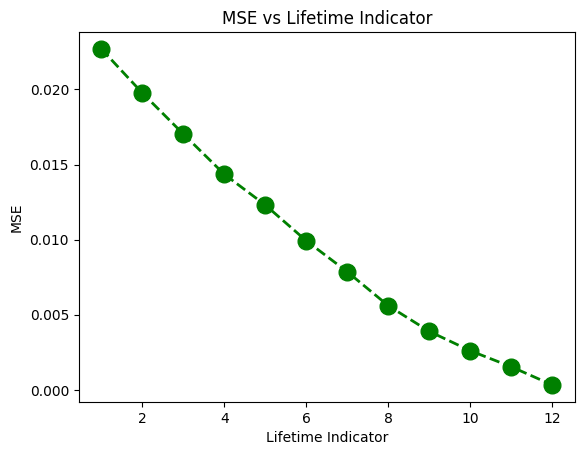

In [ ]:
import matplotlib.pyplot as plt

lifetime = list(range(1, 13))
plt.plot(lifetime, mse_values, 'go--', linewidth=2, markersize=12)
plt.xlabel('Lifetime Indicator')
plt.ylabel('MSE')
plt.title('MSE vs Lifetime Indicator')
plt.show()

Q10 For each user’s lifetime point, regress recency, frequency AND her spending behavior profile on Y. Plot the MSE for each lifetime point like above. Did you get any improvement?

In [ ]:
behavior_joined_df = joined_df.join(dynamic_profile, ["user1", "lifetime_indicator"], "inner")
behavior_joined_df.createOrReplaceTempView("behavior_joined_df")  # Create a temporary view for the DataFrame
behavior_joined_df.show(10)

+-----+------------------+--------+------------------+---------+-------+---+--------+----+-----+----+---------------+------+--------------+------+-------+------------+
|user1|lifetime_indicator|max_days|total_transactions|frequency|recency|  y|Activity|Cash|Event|Food|Illegal/Sarcasm|People|Transportation|Travel|Utility|unclassified|
+-----+------------------+--------+------------------+---------+-------+---+--------+----+-----+----+---------------+------+--------------+------+-------+------------+
|   43|                 0|       0|                 1|      0.0|      0|  2|     0.0| 0.0|  0.0| 0.0|            0.0|   0.0|           0.0|   0.0|    0.0|         1.0|
|   43|                 5|     134|                 2|     75.0|     16|  2|     0.0| 0.0|  0.0| 1.0|            0.0|   0.0|           0.0|   0.0|    0.0|         0.0|
| 3897|                 0|       0|                 1|      0.0|      0|  1|     0.0| 0.0|  0.0| 1.0|            0.0|   0.0|           0.0|   0.0|    0.0|      

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

def calculateLifetimeMSE(inputdata):
    assembler = VectorAssembler(inputCols=['lifetime_indicator', 'frequency', 'recency','Activity','Cash','Event','Food','Illegal/Sarcasm','People','Transportation','Travel','unclassified'], outputCol='x')
    output = assembler.transform(inputdata)
    finalData = output.select('x', 'y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lr = LinearRegression(labelCol='y', featuresCol='x')
    lrModel = lr.fit(trainData)
    testResults = lrModel.evaluate(testData)
    mse = testResults.rootMeanSquaredError ** 2
    return mse

mse_values_behv = []

for i in range(1, 13):
    df_input_time = spark.sql(f"select * from behavior_joined_df where lifetime_indicator={i}")
    mse = calculateLifetimeMSE(df_input_time)
    mse_values_behv.append(mse)

print(mse_values)

[0.022694376918928075, 0.01976204018303549, 0.017031376259447478, 0.014351635231168393, 0.012302664087047036, 0.00992329637362028, 0.007859571746027905, 0.005601764564645067, 0.003892405547766274, 0.0026041347375469048, 0.0015364687440044822, 0.0003276461009592181]


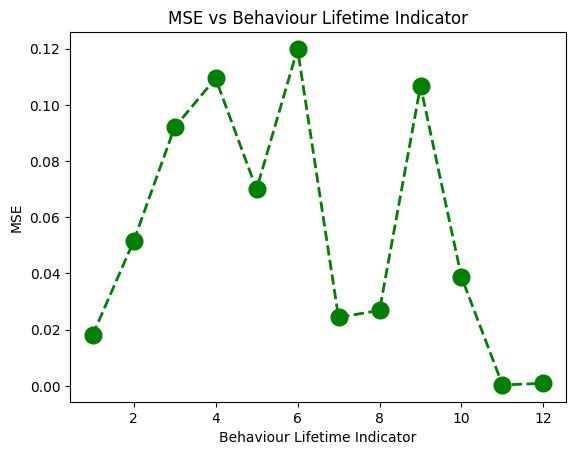

In [ ]:
import matplotlib.pyplot as plt

lifetime = list(range(1, 13))
plt.plot(lifetime, mse_values_behv, 'go--', linewidth=2, markersize=12)
plt.xlabel('Behaviour Lifetime Indicator')
plt.ylabel('MSE')
plt.title('MSE vs Behaviour Lifetime Indicator')
plt.show()

**Q11 For each user’s lifetime point, regress her social network metrics on Y.**

In [ ]:
df_total_friends.show()

+----+------------------+-------------+-------------+
|user|lifetime_indicator|no_of_friends|total_friends|
+----+------------------+-------------+-------------+
|  11|                 0|            2|            2|
|  11|                 1|            0|            2|
|  11|                 2|            0|            2|
|  11|                 3|            0|            2|
|  11|                 4|            0|            2|
|  11|                 5|            0|            2|
|  11|                 6|            0|            2|
|  11|                 7|            0|            2|
|  11|                 8|            0|            2|
|  11|                 9|            0|            2|
|  11|                10|            0|            2|
|  11|                11|            0|            2|
|  11|                12|            0|            2|
|  43|                 0|            1|            1|
|  43|                 1|            0|            1|
|  43|                 2|   

In [ ]:
df_fof_friends_cumulative.createOrReplaceTempView("df_fof_friends_cumulative")
df_fof_friends_cumulative.show()

+----+------------------+------------------------+-----------------------+
|user|lifetime_indicator|no_of_friends_of_friends|total_friend_of_friends|
+----+------------------+------------------------+-----------------------+
|  43|                 0|                       0|                      0|
|  43|                 1|                       0|                      0|
|  43|                 2|                       0|                      0|
|  43|                 3|                       0|                      0|
|  43|                 4|                       0|                      0|
|  43|                 5|                       0|                      0|
|  43|                 6|                       0|                      0|
|  43|                 7|                       0|                      0|
|  43|                 8|                       0|                      0|
|  43|                 9|                       0|                      0|
|  43|                10|

In [ ]:
clustering_coeff.show()

+------+----------------+------------------+
|vertex|clustering_coeff|lifetime_indicator|
+------+----------------+------------------+
|    11|             0.0|                 0|
|    43|             0.0|                 0|
|   173|             0.0|                 0|
|   241|             0.0|                 0|
|   275|             0.0|                 0|
|   634|             0.0|                 0|
|   946|             0.0|                 0|
|  1125|             0.0|                 0|
|  1535|             0.0|                 0|
|  1572|             0.0|                 0|
|  1581|             0.0|                 0|
|  2327|             0.0|                 0|
|  2407|             0.0|                 0|
|  2604|             0.0|                 0|
|  2763|             0.0|                 0|
|  2908|             0.0|                 0|
|  2915|             0.0|                 0|
|  2993|             0.0|                 0|
|  3111|             0.0|                 0|
|  3352|  

In [ ]:
df_pagerank.show()

+----+--------------------+
|user|            pagerank|
+----+--------------------+
|  11|1.371284560077088...|
|  43|1.371284560077088...|
| 173|7.412348973389667E-6|
| 241|7.412348973389667E-6|
| 275|4.262100659699059E-6|
| 634|7.412348973389667E-6|
| 946|4.262100659699059E-6|
|1125|7.412348973389667E-6|
|1535|7.412348973389667E-6|
|1572|7.412348973389667E-6|
|1581|7.412348973389667E-6|
|2327|7.412348973389667E-6|
|2407|7.412348973389667E-6|
|2604|7.412348973389667E-6|
|2763|7.412348973389667E-6|
|2908|7.412348973389667E-6|
|2915|7.412348973389667E-6|
|2993|7.412348973389667E-6|
|3111|7.412348973389667E-6|
|3352|4.262100659699059E-6|
+----+--------------------+
only showing top 20 rows



In [ ]:
# create input metric by combining social network metric
joined_socialnetwork_df = spark.sql("select a.user,a.lifetime_indicator,a.total_friends,b.total_friend_of_friends,c.clustering_coeff,d.pagerank,e.y\
                         from df_total_friends a inner join df_fof_friends_cumulative b on a.user = b.user and a.lifetime_indicator=b.lifetime_indicator \
                         inner join clustering_coeff c on a.user=c.vertex and a.lifetime_indicator=c.lifetime_indicator\
                         inner join df_pagerank d on a.user=d.user\
                         inner join df_with_response e on a.user=e.user1")

joined_socialnetwork_df.createOrReplaceTempView("joined_socialnetwork_df")
joined_socialnetwork_df.show()

+------+------------------+-------------+-----------------------+----------------+--------------------+---+
|  user|lifetime_indicator|total_friends|total_friend_of_friends|clustering_coeff|            pagerank|  y|
+------+------------------+-------------+-----------------------+----------------+--------------------+---+
|134705|                 0|            1|                      0|             0.0|7.412348973389667E-6|  1|
|145001|                 0|            1|                      0|             0.0|7.412348973389667E-6|  1|
|146907|                 0|            1|                      0|             0.0|7.412348973389667E-6|  1|
|148667|                 0|            1|                      0|             0.0|7.412348973389667E-6|  1|
|156189|                 0|            1|                      0|             0.0|7.412348973389667E-6|  1|
|162470|                 0|            1|                      0|             0.0|7.412348973389667E-6|  1|
|177036|                 0| 

In [ ]:
df_sn_input_time0 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=0 ")
df_sn_input_time1 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=1 ")
df_sn_input_time2 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=2 ")
df_sn_input_time3 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=3 ")
df_sn_input_time4 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=4 ")
df_sn_input_time5 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=5 ")
df_sn_input_time6 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=6 ")
df_sn_input_time7 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=7 ")
df_sn_input_time8 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=8 ")
df_sn_input_time9 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=9 ")
df_sn_input_time10 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=10 ")
df_sn_input_time11 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=11 ")
df_sn_input_time12 = spark.sql("select * from joined_socialnetwork_df where lifetime_indicator=12 ")

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
def socialnetworkMSE(inputdata):
    Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'total_friends',
                                'total_friend_of_friends', 'clustering_coeff', 'pagerank'],
                                outputCol ='features')
    output = Assembler.transform(inputdata)
    finalData = output.select('features','y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lrModel = LinearRegression(labelCol ='y', featuresCol='features')
    lrEstimator = lrModel.fit(trainData)
    testResults = lrEstimator.evaluate(testData)
    rmse = testResults.rootMeanSquaredError
    mse = rmse**2
    return mse



In [ ]:
sn_MSE_time0 = socialnetworkMSE(df_sn_input_time0)
sn_MSE_time1 = socialnetworkMSE(df_sn_input_time1)
sn_MSE_time2 = socialnetworkMSE(df_sn_input_time2)
sn_MSE_time3 = socialnetworkMSE(df_sn_input_time3)
sn_MSE_time4 = socialnetworkMSE(df_sn_input_time4)
sn_MSE_time5 = socialnetworkMSE(df_sn_input_time5)
sn_MSE_time6 = socialnetworkMSE(df_sn_input_time6)
sn_MSE_time7 = socialnetworkMSE(df_sn_input_time7)
sn_MSE_time8 = socialnetworkMSE(df_sn_input_time8)
sn_MSE_time9 = socialnetworkMSE(df_sn_input_time9)
sn_MSE_time10 = socialnetworkMSE(df_sn_input_time10)
sn_MSE_time11 = socialnetworkMSE(df_sn_input_time11)
sn_MSE_time12 = socialnetworkMSE(df_sn_input_time12)


In [ ]:
# print(sn_MSE_time0)
# print(sn_MSE_time1)
# print(sn_MSE_time2)
# print(sn_MSE_time3)
# print(sn_MSE_time4)
# print(sn_MSE_time5)
# print(sn_MSE_time6)
# print(sn_MSE_time7)
# print(sn_MSE_time8)
# print(sn_MSE_time9)
# print(sn_MSE_time10)
# print(sn_MSE_time11)
# print(sn_MSE_time12)

In [ ]:
inputdata = df_sn_input_time12
Assembler = VectorAssembler(inputCols = ['lifetime_indicator', 'total_friends',
                                'total_friend_of_friends', 'clustering_coeff', 'pagerank'],
                                outputCol ='features')
output = Assembler.transform(inputdata)
finalData = output.select('features','y')
trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
lrModel = LinearRegression(labelCol ='y', featuresCol='features')
lrEstimator = lrModel.fit(trainData)
testResults = lrEstimator.evaluate(testData)

In [ ]:
import numpy as np
summary = lrEstimator.summary
print("Root Mean Squared Error: {:.4f}".format(summary.rootMeanSquaredError))
print("Mean Absolute Error: {:.4f}".format(summary.meanAbsoluteError))
print("R-squared: {:.4f}".format(summary.r2))
print("Number of iterations: {}".format(summary.totalIterations))
print("Coefficients: {}".format(lrEstimator.coefficients))
print("Intercept: {:.4f}".format(lrEstimator.intercept))
from scipy.stats import t
#coef_standard_errors = summary.coefficientStandardErrors
coef_standard_errors = np.sqrt(np.diag(np.linalg.inv(np.dot(output.rdd.map(lambda x: np.outer(x["features"], x["features"])).reduce(lambda x, y: x + y), mse))))
# Get the coefficient values from the trained model
coefficients = lrEstimator.coefficients

# Calculate the t-values and p-values
t_values = coefficients / coef_standard_errors
degrees_of_freedom = summary.degreesOfFreedom
p_values = [2 * (1 - t.cdf(abs(t_val), degrees_of_freedom)) for t_val in t_values]

# Print the coefficient values and their corresponding p-values
for i, coef in enumerate(coefficients):
    print("Coefficient {}: {:.4f}\t\tP-value: {:.4f}".format(i, coef, p_values[i]))

Root Mean Squared Error: 0.1317
Mean Absolute Error: 0.0363
R-squared: 0.3783
Number of iterations: 10
Coefficients: [0.0,0.4316555634174808,-0.014683294681629903,-0.11019066487132996,-11773.415329531123]
Intercept: 0.6528
Coefficient 0: 0.0000		P-value: 1.0000
Coefficient 1: 0.4317		P-value: 0.6591
Coefficient 2: -0.0147		P-value: 0.9838
Coefficient 3: -0.1102		P-value: 0.9909
Coefficient 4: -11773.4153		P-value: 0.9393


In [ ]:
sn_MSE = []
sn_MSE.extend([sn_MSE_time0, sn_MSE_time1, sn_MSE_time2, sn_MSE_time3,
            sn_MSE_time4, sn_MSE_time5, sn_MSE_time6, sn_MSE_time7,
            sn_MSE_time8, sn_MSE_time9, sn_MSE_time10, sn_MSE_time11, sn_MSE_time12])

In [ ]:
# sn_MSE

<ipython-input-99-0de8fe718a50>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(Lifetime, sn_MSE, 'go--', color='red', linewidth=2, markersize=12)


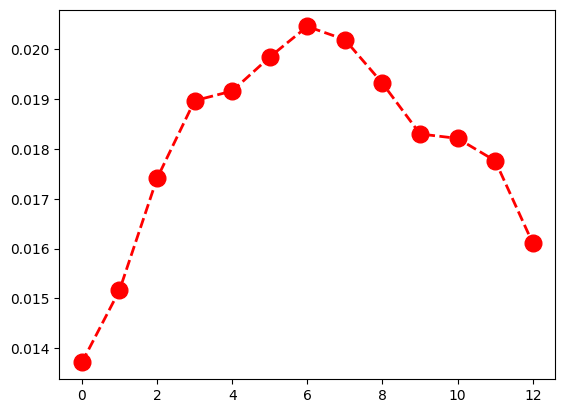

In [ ]:
import matplotlib.pyplot as plt
Lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Lifetime, sn_MSE, 'go--', color='red', linewidth=2, markersize=12)

## Q12

In [ ]:
lf_joined_df = spark.sql("SELECT b.user1 as user, b.lifetime_indicator as lifetime_indicator, \
    b.Activity as Activity, b.Cash as Cash, b.Event as Event, b.Food as Food, b.`Illegal/Sarcasm` as `Illegal/Sarcasm`, \
    b.People as People, b.Transportation as Transportation, b.Travel as Travel, b.Utility as Utility, \
    b.unclassified as unclassified, c.total_friends as total_friends, \
    c.total_friend_of_friends as total_friend_of_friends, c.clustering_coeff as clustering_coeff, \
    c.pagerank as pagerank, c.y as y \
    FROM  dynamic_profile b\
    INNER JOIN joined_socialnetwork_df c ON b.user1 = c.user and b.lifetime_indicator=b.lifetime_indicator")

lf_joined_df.createOrReplaceTempView("lf_joined_df")
lf_joined_df.show()


+------+------------------+--------+----+-----+----+---------------+------+--------------+------+-------+------------+-------------+-----------------------+----------------+--------------------+---+
|  user|lifetime_indicator|Activity|Cash|Event|Food|Illegal/Sarcasm|People|Transportation|Travel|Utility|unclassified|total_friends|total_friend_of_friends|clustering_coeff|            pagerank|  y|
+------+------------------+--------+----+-----+----+---------------+------+--------------+------+-------+------------+-------------+-----------------------+----------------+--------------------+---+
|134705|                 0|     0.0| 0.0|  1.0| 0.0|            0.0|   0.0|           0.0|   0.0|    0.0|         0.0|            1|                      0|             0.0|7.412348973389667E-6|  1|
|145001|                 0|     0.0| 0.0|  0.0| 1.0|            0.0|   0.0|           0.0|   0.0|    0.0|         0.0|            1|                      0|             0.0|7.412348973389667E-6|  1|
|1469

In [ ]:
df_sn_sbh_input_time0 = spark.sql("SELECT * FROM lf_joined_df WHERE lifetime_indicator = 0")
df_sn_sbh_input_time1 = spark.sql("select * from lf_joined_df where lifetime_indicator=1 ")
df_sn_sbh_input_time2 = spark.sql("select * from lf_joined_df where lifetime_indicator=2 ")
df_sn_sbh_input_time3 = spark.sql("select * from lf_joined_df where lifetime_indicator=3 ")
df_sn_sbh_input_time4 = spark.sql("select * from lf_joined_df where lifetime_indicator=4 ")
df_sn_sbh_input_time5 = spark.sql("select * from lf_joined_df where lifetime_indicator=5 ")
df_sn_sbh_input_time6 = spark.sql("select * from lf_joined_df where lifetime_indicator=6 ")
df_sn_sbh_input_time7 = spark.sql("select * from lf_joined_df where lifetime_indicator=7 ")
df_sn_sbh_input_time8 = spark.sql("select * from lf_joined_df where lifetime_indicator=8 ")
df_sn_sbh_input_time9 = spark.sql("select * from lf_joined_df where lifetime_indicator=9 ")
df_sn_sbh_input_time10 = spark.sql("select * from lf_joined_df where lifetime_indicator=10 ")
df_sn_sbh_input_time11 = spark.sql("select * from lf_joined_df where lifetime_indicator=11 ")
df_sn_sbh_input_time12 = spark.sql("select distinct * from lf_joined_df where lifetime_indicator=12 ")

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

def socialbheaviournetworkMSE(inputdata):
    assembler = VectorAssembler(inputCols=['lifetime_indicator','Activity','Cash','Event','Food','Illegal/Sarcasm','People','Transportation','Travel','unclassified','clustering_coeff','pagerank',], outputCol='x')
    output = assembler.transform(inputdata)
    finalData = output.select('x', 'y')
    trainData, testData = finalData.randomSplit([0.7, 0.3], seed=1)
    lr = LinearRegression(labelCol='y', featuresCol='x')
    lrModel = lr.fit(trainData)
    testResults = lrModel.evaluate(testData)
    mse = testResults.rootMeanSquaredError ** 2
    return mse

In [ ]:
sn_sbh_time0 = socialbheaviournetworkMSE(df_sn_sbh_input_time0)
sn_sbh_time1 = socialbheaviournetworkMSE(df_sn_sbh_input_time1)
sn_sbh_time2 = socialbheaviournetworkMSE(df_sn_sbh_input_time2)
sn_sbh_time3 = socialbheaviournetworkMSE(df_sn_sbh_input_time3)


In [ ]:
sn_sbh_time4 = socialbheaviournetworkMSE(df_sn_sbh_input_time4)
sn_sbh_time5 = socialbheaviournetworkMSE(df_sn_sbh_input_time5)
sn_sbh_time6 = socialbheaviournetworkMSE(df_sn_sbh_input_time6)
sn_sbh_time7 = socialbheaviournetworkMSE(df_sn_sbh_input_time7)


In [ ]:
sn_sbh_time8 = socialbheaviournetworkMSE(df_sn_sbh_input_time8)
sn_sbh_time9 = socialbheaviournetworkMSE(df_sn_sbh_input_time9)
sn_sbh_time10 = socialbheaviournetworkMSE(df_sn_sbh_input_time10)
sn_sbh_time11 = socialbheaviournetworkMSE(df_sn_sbh_input_time11)
sn_sbh_time12 = socialbheaviournetworkMSE(df_sn_sbh_input_time12)


In [ ]:
#print(sn_sbh_time0)
#print(sn_sbh_time1)
#print(sn_sbh_time2)
#print(sn_sbh_time3)
#print(sn_sbh_time4)
#print(sn_sbh_time5)
#print(sn_sbh_time6)
#print(sn_sbh_time7)
# print(sn_sbh_time8)
#print(sn_sbh_time9)
#print(sn_sbh_time10)
# print(sn_sbh_time11)
#print(sn_sbh_time12)

In [ ]:
sn_sbh_MSE = []
sn_sbh_MSE.extend([sn_sbh_time0, sn_sbh_time1, sn_sbh_time2, sn_sbh_time3,
            sn_sbh_time4, sn_sbh_time5, sn_sbh_time6, sn_sbh_time7,
            sn_sbh_time8, sn_sbh_time9, sn_sbh_time10, sn_sbh_time11, sn_sbh_time12])

In [ ]:
# sn_sbh_MSE

<ipython-input-144-7aa41447b8b7>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go--" (-> color='g'). The keyword argument will take precedence.
  plt.plot(Lifetime, sn_sbh_MSE, 'go--', color='red', linewidth=2, markersize=12)


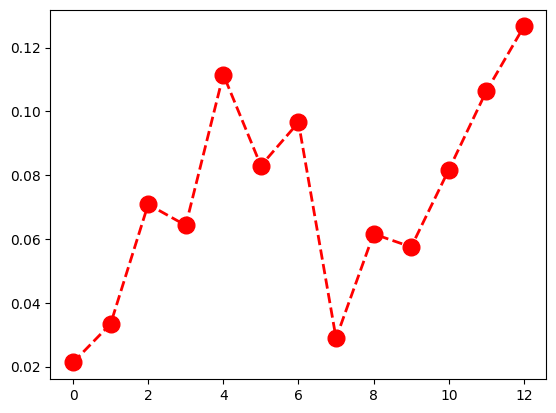

In [ ]:
import matplotlib.pyplot as plt
Lifetime = [0,1,2,3,4,5,6,7,8,9,10,11,12]
plt.plot(Lifetime, sn_sbh_MSE, 'go--', color='red', linewidth=2, markersize=12)

# Bonus Question - Matching

In [ ]:
# read parquet file
df1 = spark.read.parquet("/content/drive/Shareddrives/BAX423/Homework 4/VenmoSample.snappy.parquet")
df1.count()

match_data = df1

fraction = 0.5 # for example, read 1% of the data

# read a Parquet file and sample the data
match_data = match_data.sample(fraction)

# count total number of records
match_data.count()

3555115

In [ ]:
match_data.head()

Row(user1=3977544, user2=2709470, transaction_type='payment', datetime=datetime.datetime(2016, 9, 29, 22, 12, 7), description='Chipotlaid', is_business=False, story_id='57ed2f4723e064eac0879304')

In [ ]:
# navigate the first transaction date and only keep first 12 months transactions for each user
match_data.createOrReplaceTempView("match_data")
days_tbl = spark.sql("select user1, user2, datetime, datediff(datetime, \
                first_value(datetime) over (partition by user1 order by datetime)) as days \
                from match_data \
                group by user1, user2, datetime\
                order by user1")

In [ ]:
# add lifetime indiactor (0-12 where 0 represents the 1st transaction and 1 represents 1 month and so on)
days_lifeindicator_tbl = days_tbl.select("*",
            when(days_tbl.days==0, 0)\
         .when((days_tbl.days>0) & (days_tbl.days<=30), 1) \
         .when((days_tbl.days>30) & (days_tbl.days<=60), 2) \
         .when((days_tbl.days>60) & (days_tbl.days<=90), 3)\
         .when((days_tbl.days>90) & (days_tbl.days<=120), 4)\
         .when((days_tbl.days>120) & (days_tbl.days<=150), 5)\
         .when((days_tbl.days>150) & (days_tbl.days<=180), 6)\
         .when((days_tbl.days>180) & (days_tbl.days<=210), 7)\
         .when((days_tbl.days>210) & (days_tbl.days<=240), 8)\
         .when((days_tbl.days>240) & (days_tbl.days<=270), 9)\
         .when((days_tbl.days>270) & (days_tbl.days<=300), 10)\
         .when((days_tbl.days>300) & (days_tbl.days<=330), 11)\
         .when((days_tbl.days>330) & (days_tbl.days<=360), 12)\
         .otherwise(-1).alias('lifetime_indicator'))
days_lifeindicator_tbl.createOrReplaceTempView("days_lifeindicator_tbl")

# filter out records where "datetime-startdate">=360 days (12 months after first transaction)
lifetime_tbl = days_lifeindicator_tbl.filter("lifetime_indicator != -1 ").sort("user1")

In [ ]:
lifetime_tbl.show()

+-----+-------+-------------------+----+------------------+
|user1|  user2|           datetime|days|lifetime_indicator|
+-----+-------+-------------------+----+------------------+
|    2|    220|2012-11-23 06:03:42|   0|                 0|
|    3|     52|2016-09-22 15:30:09|   0|                 0|
|    3|1204190|2016-10-09 01:56:24|  17|                 1|
|    3|7854140|2016-10-09 03:36:13|  17|                 1|
|   10|    255|2012-11-25 09:20:39|   0|                 0|
|   10|     43|2012-12-23 11:08:45|  28|                 1|
|   10|    255|2013-01-14 08:18:43|  50|                 2|
|   10|     43|2013-03-03 12:47:10|  98|                 4|
|   10|    255|2013-03-11 04:38:51| 106|                 4|
|   10|  71056|2013-04-05 09:48:56| 131|                 5|
|   11|  57391|2012-05-24 11:30:30|   0|                 0|
|   11|  50225|2012-08-10 02:01:05|  78|                 3|
|   11|     42|2012-08-25 00:30:23|  93|                 4|
|   12|  26675|2013-05-06 05:45:39|   0|

In [ ]:
lifetime_tbl.createOrReplaceTempView("lifetime_tbl")
df_n_friends = spark.sql("select distinct user1 as user, lifetime_indicator, \
                             count(distinct user2) as no_of_friends from \
                    (select distinct user1, user2, lifetime_indicator from lifetime_tbl \
                    union select distinct user2, user1, lifetime_indicator from lifetime_tbl) T\
                   group by user1, lifetime_indicator \
                   order by user")

df_n_friends.createOrReplaceTempView("df_n_friends")

In [ ]:
# create continuous user lifetime
t_list = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_usertime = df_n_friends.select("user").withColumn("time_list", F.array([F.lit(x) for x in t_list]))
df_usertime = df_usertime.withColumn("time_list", F.explode(col("time_list")))
df_usertime.createOrReplaceTempView("df_usertime")

df_lifetime_friends = spark.sql("select user, lifetime_indicator, \
                            max(ifnull(no_of_friends,0)) as no_of_friends \
                        from \
                        (select user, lifetime_indicator, no_of_friends from df_n_friends \
                          union \
                         select user, time_list, null as no_of_friends from df_usertime) T \
                        group by user, lifetime_indicator \
                        order by user, lifetime_indicator")
df_lifetime_friends.createOrReplaceTempView("df_lifetime_friends")

In [ ]:
# continuous lifetime, number of friends, cumulative number of friends
df_total_friends = spark.sql("select user, lifetime_indicator, no_of_friends, \
                                        (sum(no_of_friends) over (partition by user \
                                        order by lifetime_indicator)) as total_friends \
                                    from df_lifetime_friends \
                                    order by user, lifetime_indicator ")

df_total_friends.createOrReplaceTempView("df_total_friends")

In [ ]:
# number of friends of friends for t=0 to 12
df_fof_friends = spark.sql("select distinct user1 as user, lifetime_indicator, \
                             count(distinct user2) as no_of_friends_of_friends \
                              from \
                                (select user1, (case when user2 is null then 0 else user2 end) as user2, lifetime_indicator from \
                                (select distinct a.user1, b.user2, a.lifetime_indicator from lifetime_tbl a \
                                left join lifetime_tbl b on a.user2 = b.user1 where a.user1 <> b.user2) T) W\
                              group by user1, lifetime_indicator \
                              order by user")

df_fof_friends.createOrReplaceTempView("df_fof_friends")

In [ ]:
df_fof_friends = spark.sql("select user1 as user,sum(case when user2 is null then 0 else 1 end) as no_of_friends_of_friends,lifetime_indicator from \
                                (select distinct a.user1, b.user2,a.lifetime_indicator as lifetime_indicator \
                                from lifetime_tbl a \
                                left join lifetime_tbl b on a.user2 = b.user1 ) T \
                                group by user1, lifetime_indicator \
                                order by user")

In [ ]:
# create continuous user lifetime
t_list = [0,1,2,3,4,5,6,7,8,9,10,11,12]
df_usertime = df_fof_friends.select("user").withColumn("time_list", F.array([F.lit(x) for x in t_list]))
df_usertime = df_usertime.withColumn("time_list", F.explode(col("time_list")))
df_usertime.createOrReplaceTempView("df_usertime")

df_lifetime_fof = spark.sql("select user, lifetime_indicator, \
                            max(ifnull(no_of_friends_of_friends,0)) as no_of_friends_of_friends \
                        from \
                        (select user, lifetime_indicator, no_of_friends_of_friends from df_fof_friends \
                          union \
                         select user, time_list, null as no_of_friends_of_friends from df_usertime) T \
                        group by user, lifetime_indicator \
                        order by user, lifetime_indicator")
df_lifetime_fof.createOrReplaceTempView("df_lifetime_fof")

In [ ]:
df_fof_friends_cumulative = spark.sql("select user, lifetime_indicator, no_of_friends_of_friends, \
                                        (sum(no_of_friends_of_friends) over (partition by user \
                                        order by lifetime_indicator)) as total_friend_of_friends \
                                    from df_lifetime_fof \
                                    order by user, lifetime_indicator ")

df_fof_friends_cumulative.createOrReplaceTempView("df_fof_friends_cumulative")

df_social = spark.sql("select a.user,a.lifetime_indicator,a.no_of_friends as first_degree_friends,a.total_friends cum_fd_friends, \
                        b.no_of_friends_of_friends as second_degree_friends,b.total_friend_of_friends as cum_sd_friends from df_total_friends a \
                        join df_fof_friends_cumulative b on a.user=b.user")

df_social.createOrReplaceTempView("df_social")
df_social.show()

+----+------------------+--------------------+--------------+---------------------+--------------+
|user|lifetime_indicator|first_degree_friends|cum_fd_friends|second_degree_friends|cum_sd_friends|
+----+------------------+--------------------+--------------+---------------------+--------------+
|  12|                 0|                   2|             2|                    0|             0|
|  12|                 0|                   2|             2|                    0|             0|
|  12|                 0|                   2|             2|                    0|             0|
|  12|                 0|                   2|             2|                    0|             0|
|  12|                 0|                   2|             2|                    0|             0|
|  12|                 0|                   2|             2|                    0|             0|
|  12|                 0|                   2|             2|                    0|             0|
|  12|    

In [ ]:
df_edges = spark.sql("select user1 as src, user2 as dst \
                from lifetime_tbl \
                group by user1,user2 \
                order by user1")

df_edges.show()

df_vertices = spark.sql("select user1 as vertex \
                from lifetime_tbl \
                union \
                select user2 as vertex from lifetime_tbl ")

df_vertices.show()

!pip install networkx
!pip install graphframes

import networkx as nx
from graphframes import GraphFrame
from graphframes import *
from graphframes.examples import Graphs
import matplotlib.pyplot as plt

window = Window.orderBy(F.col('vertex'))
df_final = df_vertices.withColumn('id', F.row_number().over(window))
df_final.select('id', 'vertex').show()

graph = GraphFrame(df_final, df_edges)

vertices = graph.vertices.toPandas()
edges = graph.edges.toPandas()
nx_graph = nx.Graph()
# Add vertices
for _, row in vertices.iterrows():
  nx_graph.add_node(row['vertex'])

# Add edges
for _, row in edges.iterrows():
  nx_graph.add_edge(row['src'], row['dst'])

+---+-------+
|src|    dst|
+---+-------+
|  2|    220|
|  3|     52|
|  3|1204190|
|  3|7854140|
| 10|     43|
| 10|    255|
| 10|  71056|
| 11|     42|
| 11|  50225|
| 11|  57391|
| 12|  26675|
| 13|     11|
| 13|   3548|
| 13| 212813|
| 16|1457073|
| 19|  85471|
| 34|   5114|
| 34|  35940|
| 42|     11|
| 43|     19|
+---+-------+
only showing top 20 rows

+------+
|vertex|
+------+
|  2866|
|  6620|
| 28170|
| 28759|
| 29894|
| 33602|
| 47283|
| 51415|
| 53963|
| 67492|
| 67861|
| 68202|
| 71995|
| 79220|
| 87616|
| 94851|
| 99454|
|109622|
|112020|
|117994|
+------+
only showing top 20 rows

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
+---+------+
| id|vertex|
+---+------+
|  1|     2|
|  2|     3|
|  3|     4|
|  4|     6|
|  5|     8|
|  6|     9|
|  7|    10|
|  8|    11|
|  9|    12|
| 10|    13|
| 11|    16|
| 12|    19|
| 1

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [ ]:
clustering_coeff = nx.clustering(nx_graph)

In [ ]:
for key,value in clustering_coeff.items():
  if value > 0:
    print(value)
    print(key)

Streaming output truncated to the last 5000 lines.
0.16666666666666666
8676302
0.16666666666666666
8676429
1.0
8677218
1.0
8677276
1.0
8677304
0.1
8677589
0.16666666666666666
8677742
0.3333333333333333
8677976
0.06666666666666667
8678376
0.06666666666666667
8678896
1.0
8678993
0.3333333333333333
8679261
0.16666666666666666
8679301
1.0
8679368
1.0
8679754
0.6666666666666666
8679885
1.0
8679961
0.16666666666666666
8679980
1.0
8680162
0.3333333333333333
8680356
1.0
8680794
0.16666666666666666
8681022
0.16666666666666666
8681032
1.0
8681090
0.16666666666666666
8681308
0.6
8681378
1.0
8681450
1.0
8681716
0.3333333333333333
8682320
0.06060606060606061
8682674
1.0
8683695
0.3333333333333333
8684057
0.6666666666666666
8684216
0.3333333333333333
8684865
0.3333333333333333
8685352
0.14285714285714285
8685369
0.3333333333333333
8685810
1.0
8686260
1.0
8686635
1.0
8686834
0.3333333333333333
8687598
1.0
8687969
1.0
8688918
0.2
8689039
0.3333333333333333
8689291
1.0
8689880
0.16666666666666666
86902

Here user 157033 has a clustering coefficient of 1. This means he is part of a highly connected community. Lets see how the number of transactions of another user is influenced when they enter this user's community

Lets look at the transactions for user 157033

In [ ]:
match_data.where((match_data.user1 == 157033) | (match_data.user2 == 157033)).sort('datetime').count()

66

This user joined Venmo in 2013 and has made 60 transactions since then. Now lets find this user's community - friends of this user

In [ ]:
user_157033_community = spark.sql('with cte1 as (select user2 as user from match_data where user1 = 157033 \
                                    union select user1 as user from match_data where user2 = 157033)\
                                    select user1 as friends from match_data where user2 in (select user from cte1) \
                                    union \
                                    select user2 as friends from match_data where user2 in (select user from cte1) ')
user_157033_community.createOrReplaceTempView("user_157033_community")
user_157033_community.show(100)

+--------+
| friends|
+--------+
|  220439|
| 2633962|
|  265796|
|  423556|
|  757874|
|  197589|
| 2064993|
|  128102|
|  417805|
|  668689|
|  524161|
| 3281257|
|  469430|
|15500157|
|  348221|
| 1873251|
|  627739|
| 2159649|
|  388598|
| 1073637|
|  328296|
|  313861|
|  518884|
|  213006|
|  274634|
|  491150|
|  176781|
|  714806|
| 4957596|
| 1573330|
|  157033|
| 2911677|
|  464122|
|  492999|
|  554945|
|  128106|
|  415713|
|  320523|
|  325743|
+--------+



In [ ]:
user_157033_community.count()

39

This user has 54 people in their community. Now lets look at another user 2064993 who joined Venmo in July, 2015.

This user had made 3 transactions prior to interacting with user 157033 and they were sparse transactions

In [ ]:
match_data.where(((match_data.user1 == 2064993) | (match_data.user2 == 2064993)) & (match_data.datetime <= '2015-12-04' )).sort('datetime').show(40)

+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|2064993|2911677|          charge|2015-03-09 11:01:55|             change?|      false|54fd1b33cd03c9af2...|
|2064993| 328296|         payment|2015-06-13 01:48:13|you deserve to ow...|      false|557b296df3fe5a55f...|
|2064993| 157033|         payment|2015-07-25 10:20:09|                 ATM|      false|55b300697b937252d...|
|2064993| 157033|         payment|2015-07-27 21:03:16|                 idk|      false|55b63a24e855747da...|
|2911677|2064993|         payment|2015-07-29 05:38:10|   There ya go buddy|      false|55b80452d4aeb60ca...|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+



First transaction between user 157033 and 2064993 happened in July 2015. This can be read as in Dec 2015 user 2064993 entered a highly connected community

In [ ]:
match_data.where((match_data.user1 == 157033) & (match_data.user2 == 2064993)).sort('datetime').show(40)


+------+-------+----------------+-------------------+-----------------+-----------+--------------------+
| user1|  user2|transaction_type|           datetime|      description|is_business|            story_id|
+------+-------+----------------+-------------------+-----------------+-----------+--------------------+
|157033|2064993|          charge|2016-02-29 13:59:10|   big bear booze|      false|56d3de2ecd03c9af2...|
|157033|2064993|          charge|2016-04-06 11:51:59|          bracket|      false|570495efcd03c9af2...|
|157033|2064993|          charge|2016-06-02 01:21:11|       tb brekkie|      false|574f2797cd03c9af2...|
|157033|2064993|          charge|2016-07-05 23:24:23|            drink|      false|577bdf3723e064eac...|
|157033|2064993|          charge|2016-08-08 10:41:03|saturday finances|      false|57a7ff4f23e064eac...|
+------+-------+----------------+-------------------+-----------------+-----------+--------------------+



Below you can see that after July 2015, this user has made a lot more transactions and with higher frequency. Hence showing the power of a highly connected community.

In [ ]:
match_data.where((match_data.user1 == 2064993) | (match_data.user2 == 2064993)).sort('datetime').show(100)

+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|   user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|
+--------+-------+----------------+-------------------+--------------------+-----------+--------------------+
| 2064993|2911677|          charge|2015-03-09 11:01:55|             change?|      false|54fd1b33cd03c9af2...|
| 2064993| 328296|         payment|2015-06-13 01:48:13|you deserve to ow...|      false|557b296df3fe5a55f...|
| 2064993| 157033|         payment|2015-07-25 10:20:09|                 ATM|      false|55b300697b937252d...|
| 2064993| 157033|         payment|2015-07-27 21:03:16|                 idk|      false|55b63a24e855747da...|
| 2911677|2064993|         payment|2015-07-29 05:38:10|   There ya go buddy|      false|55b80452d4aeb60ca...|
| 2064993|5038762|         payment|2016-01-05 23:52:54|                   m|      false|568be6d7cd03c9af2...|
|  157033|

In [ ]:
user_2064993_transactions = spark.sql('select count(1) as no_of_transactions from match_data a join user_157033_community b on a.user2 = b.friends where user1 = 2064993 \
                                        union \
                                        select count(1) as no_of_transactions from match_data a join user_157033_community b on a.user1 = b.friends where user2 = 2064993')
user_2064993_transactions.createOrReplaceTempView("user_2064993_transactions")
user_2064993_transactions.show()

+------------------+
|no_of_transactions|
+------------------+
|                 8|
|                 9|
+------------------+



17 of the 20 transactions for this user happened with users in the community. This proves that joining a highly connected community does have an effect on the number of transactions for a person

Now lets look at a user will a lower clustering coefficient and find their community

In [ ]:
match_data.where((match_data.user1 == 593238) | (match_data.user2 == 593238)).sort('datetime').show()

+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime|         description|is_business|            story_id|
+-------+-------+----------------+-------------------+--------------------+-----------+--------------------+
|3748564| 593238|         payment|2015-09-02 10:24:00|            🍆🍗😋🍴|      false|55e66bd0cd03c9af2...|
| 624645| 593238|         payment|2015-12-14 15:20:13|             We back|      false|566e6dadcd03c9af2...|
| 593238| 624645|         payment|2015-12-22 04:46:19|                  🔥|      false|5678651bcd03c9af2...|
|3748564| 593238|         payment|2016-01-05 04:23:25|                  😄|      false|568ad4bdcd03c9af2...|
|1100904| 593238|         payment|2016-01-11 06:30:13|      Knots on knots|      false|5692db75cd03c9af2...|
| 593238| 624645|          charge|2016-03-30 11:46:38|               Riser|      false|56fb5a2fcd03c9af2...|
| 624645| 593238|        

In [ ]:
match_data.where((match_data.user1 == 593238) | (match_data.user2 == 593238)).sort('datetime').count()

14

The user 593238 joined Venmo in March 2014 and has 12 transactions and a clustering coefficient of 0.167

In [ ]:
match_data.where(((match_data.user1 == 199537) | (match_data.user2 == 199537)) & (match_data.datetime <= '2015-05-04')).sort('datetime').show()

+------+------+----------------+-------------------+--------------------+-----------+--------------------+
| user1| user2|transaction_type|           datetime|         description|is_business|            story_id|
+------+------+----------------+-------------------+--------------------+-----------+--------------------+
|199537|319331|         payment|2014-07-07 06:43:05|Like shyit nukka ...|      false|53b9df097d0b0354e...|
+------+------+----------------+-------------------+--------------------+-----------+--------------------+



This user has had one transaction before the transaction with user 199537.

Now lets get the community of the user 593238 who has a clustering coefficient of 0.167

In [ ]:
user_593238_community = spark.sql('with cte1 as (select user2 as user from match_data where user1 = 593238 \
                                    union select user1 as user from match_data where user2 = 593238)\
                                    select user1 as friends from match_data where user2 in (select user from cte1) \
                                    union \
                                    select user2 as friends from match_data where user2 in (select user from cte1) ')
user_593238_community.createOrReplaceTempView("user_593238_community")
user_593238_community.show(100)

+-------+
|friends|
+-------+
|3240150|
| 275188|
| 824233|
| 593238|
| 796957|
| 859391|
|1088630|
| 563504|
| 923886|
| 236648|
| 497832|
|2785073|
|1113338|
| 690636|
|1318084|
|3633056|
|1458916|
|1087728|
| 708922|
| 122188|
| 252761|
| 425791|
|3674931|
| 553240|
| 508861|
|6216914|
| 911423|
| 624645|
|2446045|
|1100904|
+-------+



Now lets see user 199537, who joined the above user's community in May 2015, transactions with the community

In [ ]:
user_199537_transactions = spark.sql('select count(1) as no_of_transactions from match_data a join user_593238_community b on a.user2 = b.friends where user1 = 199537 \
                                        union \
                                        select count(1) as no_of_transactions from match_data a join user_593238_community b on a.user1 = b.friends where user2 = 199537')
user_199537_transactions.createOrReplaceTempView("user_199537_transactions")
user_199537_transactions.show()

+------------------+
|no_of_transactions|
+------------------+
|                 0|
+------------------+



As you can see this user has only 0 transactions within the community. This shows that joining a low connected community doesnt influence a person's spending behaviour.